In [1]:
# Load necessary modules
import numpy as np
np.random.seed(1)
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import plotly.express as px
import pickle
from scipy.stats import kurtosis,skew,norm,kstest,spearmanr
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
import warnings
from sklearn.svm import OneClassSVM
warnings.filterwarnings('ignore')

In [2]:
def load_data_util(DIR,no_of_samples):
    """
    Loads the data from CSV files present in the given directory into a numpy nd-array.
    
    INPUT: 
        DIR: Directory name
        no_of_samples: No. of samples in each csv file
        
    RETURNS:
        loaded_values: Numpy array of the loaded values.
    NOTE:
        Requires numpy
        
    """
    filenames = [name for name in os.listdir(os.path.join(DIR))]
    
    loaded_values = np.zeros((len(filenames),no_of_samples,1))
    
    for i in range(1,len(filenames)+1):
        loaded_values[i-1:i,:,:] = np.loadtxt(os.path.join(DIR+str(i),'dataconvertedv1.txt')).reshape(no_of_samples,1)
    
    return loaded_values
def load_data(DIR,list_of_folders,no_of_samples,filename):
    """
    Loads the data from a list of folders containing CSV files, if not already loaded and dumps it into a pickle file for faster loading in future.
    
    INPUT:
        DIR: directory in which the folders are present
        list_of_folders: list of names of folders in DIR
        no_of_samples: No. of samples in each csv file
        filename: the name of the pickle file in which the data is to be dumped
        
    """
    if filename in os.listdir("."):
        print("data already loaded.")
    else:
        datalist = []
        list_of_folders = sorted(list_of_folders)
        for folder in list_of_folders:
            datalist.append(load_data_util(DIR+'/'+folder+'/',no_of_samples))
        data = datalist[0]
        for i in range(1,len(datalist)):
            data = np.concatenate((data,datalist[i]),axis=2)
        data = data/(2**16/2-1)*4*9.81
        for i in range(data.shape[-1]):
            data[:,:,i] = (data[:,:,i]-data[:,:,i].mean(axis=1,keepdims=True))/data[:,:,-1].std(axis=1,keepdims=True)
        with open(filename, "wb") as file:
            pickle.dump(data, file)

In [3]:
def plot_magnitude_spectrum(signal1,title,sr,labels,fratio = 1,start = 0,end = 0,useratio = True,signal2 = None):
    """
    Plots the frequency magnitude spectrum of the signal(s).
    
    INPUT:
        signal1: array_like
        title: Title of the plot
        sr: Sampling rate of the signal(s)
        labels: A list of size 1 or 2, depending whether signal 2 is None or not
        fratio: A float, portion of the magnitude spectrum to plot, default = 1
        start: starting frequency 
        end: end frequency
        useratio: If false, the plot between start and end is plotted, default = True
        signal2: array_like,default = None
        
    """
    ft1 = np.fft.fft(signal1)  # Take the ftt of signal 1
    
    magnitudes1 = np.abs(ft1)  # Get the magnitudes of each sample frequency
    
    freq1 = np.fft.fftfreq(len(signal1))*sr   # Get the sample frequencies
    
    if signal2 is not None:    # Repeat the above for signal 2 if not None
        ft2 = np.fft.fft(signal2)
        magnitudes2 = np.abs(ft2)
        freq2 = np.fft.fftfreq(len(signal2))*sr
        
    plt.figure(figsize=(18,5))
    
    if signal2 is not None:
        if useratio:
            num_freq_bins1 = int(len(freq1)*fratio)
            num_freq_bins2 = int(len(freq2)*fratio)
            plt.plot(freq1[:num_freq_bins1],magnitudes1[:num_freq_bins1],color = 'purple',label=labels[0])
            plt.plot(freq2[:num_freq_bins2],magnitudes2[:num_freq_bins2],color = 'orange',label=labels[1])
        else:
            plt.plot(freq1[(freq1>=start) & (freq1<=end)],magnitudes1[(freq1>=start) & (freq1<=end)],color='purple',label=labels[0])
            plt.plot(freq2[(freq2>=start) & (freq2<=end)],magnitudes2[(freq2>=start) & (freq2<=end)],color='orange',label=labels[1])
    else:
        if useratio:
            num_freq_bins = int(len(freq1)*fratio)
            plt.plot(freq1[:num_freq_bins],magnitudes1[:num_freq_bins],color = 'purple',label=labels[0])
        else:
            plt.plot(freq1[(freq1>=start) & (freq1<=end)],magnitudes1[(freq1>=start) & (freq1<=end)],color='purple',label=labels[0])
            
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.title(title)
    plt.show()

In [4]:
def sign(arr):
    """
    Returns a numpy array containing 1,0 and -1. 1 represents positive numbers,-1 represents negative numbers and 0 represents the number zero.
    
    INPUT: 
        arr: a numpy array
    RETURNS:
        sign_arr: a numpy array of 1s,0s and -1s.
        
    Eg:
        In: sign(np.array([ 1, 2, -1, -2, 0, -2]))
        Out: array([ 1,  1, -1, -1,  0, -1])
        
    """
    sign_arr = np.where(arr>0,1,np.where(arr<0,-1,0))
    return sign_arr
def zero_crossings(data,threshold = 0.015):
    """
    Calculates the no. of zero crossings in given data.
    
    INPUT:
        data: a 1-D numpy array
        threshold: Required minimum difference between consecutive entries in the data (useful in case of noisy data),default value is 0.015
    RETURNS:
        the no. of zero crossings
    
    Eg:
        In: data = np.array([1,-1,2,3])
            print(zero_crossings(data))
        Out: 2.0
        
    """
    a,b = data[:-1],data[1:] 
    
    a1,b1 = sign(a),sign(b)
    
    diff = abs(a-b)          #Taking difference between consecutive values
    
    a1,b1 = a1[diff>=threshold],b1[diff>=threshold]
    
    zc = np.floor(np.sum(abs(a1-b1))/2) #Opposite signs get added up to 2 and finally we divide by 2 to get our ans
    return zc

In [5]:
def frequency_domain(raw_data,sampling_rate):
    """
    Extracts frequency domain features which are: mean, kurtosis, homogenity, amplitudes around inner and outer race fault frequencies, mean of the magnitudes of higher frequencies.
    
    INPUT:
        raw_data: a numpy array of shape (n,m),i.e (Total no. of files, No. of samples in each file)
        sampling_rate: the rate at which the data is sampled
    RETURNS:
        fft_features: a list of extracted frequency domain features
        
    """
    fft_features = []
    
    fourier_transform = np.fft.fft(raw_data) # Calculates the discrete fourier transform
    
    fft_freq = np.fft.fftfreq(raw_data.shape[-1])*sampling_rate  # Calculates the discrete fourier transform sample frequencies
    
    magnitudes = np.abs(fourier_transform) # Gets the magnitudes of the frequencies
    
    # Since the frequency spectrum is symmetrical, we consider frequencies from 0 to half of sampling rate
    fft_features.append(magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))].mean(axis=1).tolist()) # Mean
    
    fft_features.append(kurtosis(magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))],axis=1).tolist()) # Kurtosis
    
    # Homeginity = max/mean
    fft_features.append((magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))].max(axis=1)/magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))].mean(axis=1)).tolist())
    
    
    # Checking the mean of magnitudes of bins of frequencies 
    bins = [0,100,200,300,400,500]
    for i in range(len(bins)-1):
        fft_features.append(magnitudes[:,(fft_freq>bins[i]) & (fft_freq<=bins[i+1])].mean(axis=1).tolist())
        
    return fft_features

def time_domain(raw_data):
    """
    Extracts time domain features which are: mean absolute value, stddev, median, max, skewness, kurtosis, RMS value, zero crossing rate,form factor
    
    INPUT:
        raw_data: a numpy array of shape (n,m),i.e (Total no. of files, No. of samples in each file)
    RETURNS:
        t_features: a list of time domain features
        
    """
    t_features = []
    
    t_features.append(abs(raw_data).mean(axis=1).tolist()) # Mean absolute value
    
    t_features.append(raw_data.std(axis=1).tolist())  # standard deviation
    
    t_features.append(np.median(raw_data,axis=1).tolist())  # median
    
    t_features.append(raw_data.max(axis=1).tolist())  # Max
    
    t_features.append(skew(raw_data,axis=1).tolist())  # Skewness
    
    t_features.append(kurtosis(raw_data,axis=1).tolist())  # Kurtosis
    
    rms = np.sqrt(np.sum(raw_data**2,axis=1)/raw_data.shape[1])  # RMS value
    t_features.append(rms.tolist())
    
    t_features.append((rms/raw_data.mean(axis=1)).tolist())  # Form factor = RMS/mean
    
    zcr = np.zeros(raw_data.shape[0])
    for i in range(raw_data.shape[0]):    # Calculating zero crossing rate
        zcr[i] = zero_crossings(raw_data[i])
    t_features.append(zcr.tolist())
    
    return t_features

def feature_extraction(filename,pickle_filename,sampling_rate):
    """
    Extracts time and frequency domain features for each of the bearings from scratch(if not extracted already) and dumps the extracted features in a pickle for faster loading in future.
    
    INPUT:
        filename: the name of the pickle file in which the data was dumped previously
        pickle_filename: the name of the pickle file in which the extracted features are to be dumped
        sampling_rate: the rate at which the data was sampled
    RETURNS:
        bearings: a list of numpy arrays consisting of features for each bearing
        
    """
    with open(filename,"rb") as file:
        raw_data = pickle.load(file)
    if pickle_filename in os.listdir("."):
        print(f'Loading features from pickle.')
        with open(pickle_filename,"rb") as file:
            motor_features = pickle.load(file)
    else:
        print(f'Extracting features from scratch.')
        features_list = []
        for i in range(raw_data.shape[-1]):
            features = time_domain(raw_data[:,:,i])
            features.extend(frequency_domain(raw_data[:,:,i],sampling_rate))
            features = np.array(features).T
            features_list.append(features)
        print(features_list[0].shape)
        motor_features = features_list[0]
        for i in range(1,len(features_list)):
            motor_features = np.concatenate((motor_features,features_list[i]),axis=1)
        with open(pickle_filename,"wb") as file:
            pickle.dump(motor_features,file)
    return motor_features

In [6]:
def scale(data,test_size=0.5, scaling_technique = 'robust'):
    """
    Scales the data with respect to the choice of scaler passed. Fits the scaler on training data and uses it to transform the entire data.
    
    INPUT:
        data: Data to be scaled
        test_size: Default 0.5
        scaling_technique: {"robust","minmax","standard"}, default = "robust"
    RETURNS:
        scaler: the scaler object
        values: scaled data
    NOTE:
        Requires sklearn
        
    """
    train_size = int(data.shape[0]*(1-test_size)) # Get the train length
    
    if scaling_technique == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_technique == 'standard':
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
        
    scaler.fit(data[:train_size])   # Fit on training data
    
    values = scaler.transform(data)
    
    return scaler,values

def split_sequences(data, time_steps):
    """
    Used to build input and output sequences in which time_steps no. of points are used as input and the immediate next point is the output.
    
    INPUT:
        data: A 2-D numpy array
        time_steps: No. of timesteps to use as input.
    RETURNS:
        X: numpy array of shape(no_of_samples-time_steps,time_steps,no_of_features) 
        y: numpy array of shape(no_of_samples-time_steps,1)
        
    Eg:
  (i)   In: data = np.array([1,2,3,4,5,6]).reshape(-1,1)
            X,y = split_sequences(data,3)
            print(f'Input = {X}')
            print(f'Output = {y}')
        Out: Input = [[[1.]
                       [2.]
                       [3.]]

                      [[2.]
                       [3.]
                       [4.]]

                      [[3.]
                       [4.]
                       [5.]]]
            Output = [[4]
                      [5]
                      [6]] 
  (ii)  In: data = np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])
            X,y = split_sequences(data,3)
            print(f'Input = {X}')
            print(f'Output = {y}')
        Out: Input = [[[1. 2.]
                       [3. 4.]
                       [5. 6.]]

                      [[3. 4.]
                       [5. 6.]
                       [7. 8.]]]
             Output = [[ 7  8]
                       [ 9 10]]
                       
    """
    X = np.zeros((data.shape[0]-time_steps,time_steps,data.shape[-1]))
    
    for i in range(data.shape[0]-time_steps):
        X[i,:,:] = data[i:i+time_steps,:]
        
    y = data[time_steps:]
    
    return X,y

def split_data(X,y=None, test_size = 0.5):
    """
    Splits the input and target data into train and test sets.
    
    INPUT:
        X: a numpy array
        y: the target numpy array
        test_size: Default 0.5
    RETURNS:
        X_train: training input
        X_test: testing input
        y_train: training output
        y_test: testing output
        
    """
    length = X.shape[0]
    train_length = length - int(length*test_size)
    X_train = X[:train_length]
    if y is not None:
        y_train = y[:train_length]
    X_test = X[train_length:]
    if y is not None:
        y_test = y[train_length:]
    if y is None:
        return X_train,X_test
    return X_train, X_test, y_train, y_test

def prepare_data(data,time_steps,test_size=0.5,scaling_technique = 'robust'):
    """
    Function to scale the data, build input and output sequences, and split the processed data into train and test sets.
    
    INPUT:
        data: a 2-D numpy array
        time_steps: No. of timesteps to use as input.
        test_size: Default 0.5
        scaling_technique: {"robust","minmax","standard"}, default = "robust"
    RETURNS: 
        scaler: the scaler object
        X_train: training input
        X_test: testing input
        y_train: training output
        y_test: testing output
        
    """
    scaler,scaled_data = scale(data,test_size,scaling_technique)  # First the data is scaled
    
    X,y = split_sequences(scaled_data,time_steps)   # Build the input and output sequences from the scaled data
    
    X_train, X_test, y_train, y_test = split_data(X,y,test_size)   # Split X,y into train and test sets
    
    return scaler,X_train, X_test, y_train, y_test

def build_model(X_train,y_train,timesteps,lstm1_units = 100,lstm2_units = 50,learning_rate = 0.01,
                batch_size = 30,epochs = 100,validation_size = 0.2,verbose = 1):
    """
    Builds a stacked LSTM model.
    
    INPUT:
        X_train: A 3-D numpy array of shape (no_of_samples,timesteps,no_of_features)
        y_train: A 2-D numpy array of shape (no_of_samples,no_of_features)
        timesteps: Timesteps to use as input, should be same as X_train.shape[1]
        lstm1_units: No. of hidden units in 1st layer of LSTM, default = 100
        lstm2_units: No. of hidden units in 2nd layer of LSTM, default = 50
        learning_rate: Learning rate for adam optimizer, default = 0.01
        batch_size: Batch size to use while fitting the model, default = 30
        epochs: No. of times to work through the entire training set, default = 100
        validation_size: Between 0 to 1, default 0.2
        verbose: {0,1},whether to display the training process or not, default = 1.
    RETURNS:
        model: stacked LSTM model
        hist: history of the model (captures loss,validation loss over the training period)
        
    """
    model = Sequential()
    
    # 1st LSTM layer, relu is used as activation function.
    model.add(LSTM(lstm1_units,activation='relu',return_sequences=True,input_shape=(timesteps,X_train.shape[-1])))
#     kernel_regularizer=tf.keras.regularizers.l2(0.01)
    model.add(Dropout(0.3))
    
    model.add(LSTM(lstm2_units))
    
#     model.add(Dropout(0.3))   # adding dropout for preventing overfitting

    model.add(Dense(y_train.shape[-1]))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mse',optimizer=optimizer)   # MSE is used as loss function
    
    hist = tf.keras.callbacks.History()
    
    hist = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_size,shuffle=True,verbose=verbose)
    
    return model,hist

In [7]:
def plot_pred_and_actual(data,model,scaler,timesteps,features,num_rows = 3,num_cols = 3,figsize = (15,12)):
    """
    Plots predicted and actual values of each of the features in the data.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        model: Trained model to use for prediction
        scaler: scaler object fitted on training data
        timesteps: Timesteps to use as input
        features: A list of feature names
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,12)
    NOTE:
        Requires matplotlib
    """
    scaled_data = scaler.transform(data) # scale the entire data
    
    X,y = split_sequences(scaled_data,timesteps)  # Get the input and output sequences
    
    y_pred = model.predict(X)   # Make predictions
    
    fig=plt.figure(figsize=figsize)
    
    plot_no = 1
    
    for col in range(len(features)):
        plt.subplot(num_rows,num_cols,plot_no)
        plt.plot(y[:,col],label='True')
        plt.plot(y_pred[:,col],label='Predicted')
        plt.ylabel(features[col])
        plt.xlabel('Timesteps')
        plt.title(features[col])
        plot_no += 1
        

    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    
    by_label = dict(zip(label,line))
    
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

In [8]:
def f_calculate_thresholds(combined_uncertainties, phi=0.95):

    """

    Calculates EDMF thresholds for provided target reliability of identification



    Developed by :   Sai G.S. Pai (ETH Singapore)

    Contact :        saiganesh89@gmail.com

    Date:            June 30, 2020



    INPUTS:

        combined_uncertainties : numpy array with each column containing combined uncertainty samples for each measurement point

        phi : target reliability of identification



    OUTPUTS:

        thresholds : numpy array with each row containing lower and upper bound uncertainty threshold values for each measurement point



    NOTE:

        Requires numpy



    """

    import numpy as np

    # set phi

    phi = float(phi) ** (1 / combined_uncertainties.shape[1])       # float to ensure value is numeric not list

#     print("Phi = ", phi)        # Check Phi



    # Initialize search

    step_size = 1

    length = int((1 - phi) * combined_uncertainties.shape[0] / step_size)

    perc_calculation = np.zeros(shape=(length, 3))

    thresholds = np.zeros(shape=(combined_uncertainties.shape[1], 2))



#     print("*** Starting search for thresholds ***")

    for sens_num in range(0, combined_uncertainties.shape[1]):

        temp_array = np.sort(combined_uncertainties[:, sens_num])       # sort samples in ascending order

        for iter_num in range(0, length):

            temp = np.zeros(shape=(1, 3))

            endA_init_samples = np.arange(0, 1 + (iter_num * step_size))        # end A is for the lower bound

            endB_init_samples = np.arange(len(endA_init_samples), len(endA_init_samples) +

                                          np.around(phi * len(temp_array)), dtype=int)      # end B is for the upper bound

            temp[0, 0] = np.max(temp_array[endA_init_samples])

            temp[0, 1] = np.max(temp_array[endB_init_samples])

            # calculate percentile range for each step

            temp[0, 2] = np.max(temp_array[endB_init_samples]) - np.max(temp_array[endA_init_samples])

            perc_calculation[iter_num, :] = temp



        threshold_idx = np.where(perc_calculation[:, 2] ==

                                 np.amin(perc_calculation[:, 2]))       # get index of lowest percentile range

        # EDMF thresholds corresponding to lowest percentile range

        thresholds[sens_num, :] = perc_calculation[threshold_idx, [0, 1]]



#     print(thresholds)



    return thresholds

    # numpy array with size number_measurements x 2



In [9]:
def calc_errors(data,model,scaler,timesteps,features,healthy_data_len,num_rows = 3,num_cols = 3,figsize = (15,15)):
    """
    Calculates standardised errors between predicted and actual values and plots the PDF of the errors of the healthy portion.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        model: Trained model to use for prediction
        scaler: scaler object fitted on training data
        timesteps: Timesteps to use as input
        features: A list of feature names
        healthy_data_len: Length of healthy portion of data
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,15)
    RETURNS:
        errors_std: 2-D numpy array of shape (n_samples,n_features)
        normal_errors_std: 2-D numpy array of shape (healthy_data_len,n_features)
        
    """
    scaled_data = scaler.transform(data)  # scale the data

    X,y = split_sequences(scaled_data,timesteps)   # Get the input and output sequences
    
    y_pred = model.predict(X)   # Make predictions
    
    if y_pred.shape[-1] != y.shape[-1]:
        y = y[:,:-1]    # Removing the slip value
    
    errors = (y_pred-y)   # Compute errors 
    
    normal_errors = errors[:healthy_data_len]   # Store errors from healthy part
    
    errors_std = (errors-normal_errors.mean(axis=0))/normal_errors.std(axis=0)   # Standardize the errors
    
    normal_errors_std = errors_std[:healthy_data_len]  
    
    plt.figure(figsize=figsize)
    
    plot_no = 1
    
    # Plotting the PDF
    df = pd.DataFrame(normal_errors_std,columns=features)

    for col in df.columns:
        plt.subplot(num_rows,num_cols,plot_no)
        sns.kdeplot(data=df,x=col,fill=True)
        plot_no += 1
        
    return errors_std,normal_errors_std,normal_errors

def KStest(data,features):
    """
    Performs KS Test on th data to check for normality.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        features: A list of feature names
        
    """
    for i in range(data.shape[-1]):
        
        stats,pval = kstest(data[:,i],'norm')  # Using scipy KS Test function
        
        print(f'p-value for errors of feature {features[i]}: {pval}')
        
        # Reject null hypothesis if p-value is less than or equal to 0.05
        if pval>0.05:
            print('Do not reject null hypothesis (The distribution of RV is normal)\n')
        else:
            print("Reject the null hypothesis (RV doesnt follow a normal distribution)\n")
            
def QQPlot(data,features):
    """
    Quantile-Quantile plot of data vs the normal distribution.
    
    INPUT:
        data: A 2-D numpy array of shape (n_samples,n_features), must be standardized
        features: A list of feature names
        
    """
    for i in range(data.shape[-1]):
        print(features[i])
        fig = sm.qqplot(data[:,i],line='45') 
        plt.show()

def anomaly(normal_errors,errors,normal_dist_errors,feature_names,timewindow_len,level0_threshold,level1_threshold,min_delta = 0.01,num_rows = 3,num_cols = 3,figsize = (15,12),verbose = 1):
    """
    Function used to detect anomaly. A level 0 warning is triggered if within a time window the no. of times the errors continuously cross the upper and lower bounds is greater than or equal to the level 0 threshold.
    If we get continuously level1_threshold amount of level 0 warnings, then the level 1 warning is triggered, i.e anomaly is detected at that timestep. 
    
    INPUT:
        normal_errors: 2-D numpy array of shape (len_of_healthy_data,n_features), standardised errors till the healthy portion of the data
        errors: 2-D numpy array of shape (n_samples,n_features), standardised errors from the entire data
        normal_dist_errors: A list specifying True for normal_errors which are normally distributed else false
        feature_names: A list of feature names
        timewindow_len: Length of the time window to watch
        level0_threshold: Threshold for level 0 warning
        level1_threshold: Threshold for level 1 warning
        min_delta: Minimum difference between error and upper/lower bound (Helps to reduce the no. of false level 0 warnings)
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,12)
        verbose: Whether or not to print the timesteps at which warnings are triggered, default = 1
    
    """
    fig=plt.figure(figsize=figsize)
    plot_no = 1
    lines = []
    labels = []
    
    for col in range(normal_errors.shape[-1]):
        plt.subplot(num_rows,num_cols,plot_no)
        plt.title(feature_names[col])
        if normal_dist_errors[col]: 
            # If errors are normally distributed, calculate lower and upper bound using +3,-3 std devs.
            mean = normal_errors[:,col].mean()
            std = normal_errors[:,col].std()
            upper = mean + 3*std
            lower = mean - 3*std
        else:
            # else calculate the 99th and 1st percentiles as upper and lower bounds consecutively.
            thresholds = f_calculate_thresholds(normal_errors[:,col].reshape(-1,1),0.99)
            thresholds = np.squeeze(thresholds)
            lower,upper = thresholds[0],thresholds[1]
            
        lines.append(plt.axhline(lower,ls='--',label = 'Error thresholds',color = 'limegreen'))
        lines.append(plt.axhline(upper,ls='--',color = 'limegreen'))
        lines.append(plt.plot(errors[:,col],ls='-',color = 'dodgerblue'))
        lines.append(plt.xlabel('Timesteps'))
        lines.append(plt.ylabel('Errors'))
        
        level0 = 0    # Maintain a counter to track the level 0 warnings
        
        i = 0
        
        level0_signal = False
        
        while i < len(errors)-timewindow_len:
            # Consider the errors within the time window
            temp_errors = errors[i:i+timewindow_len,col]
            mask1 = (temp_errors > upper) & (abs(temp_errors - upper) > min_delta)   # For crossing upper bound
            mask2 = (temp_errors < lower) & (abs(temp_errors - lower) > min_delta)   # For crossing lower bound
            mask = mask1 | mask2   # Either crosses upper or lower bound
            
            res,temp_res = 0,0    # For counting the no. of times errors continuously cross the bounds
            last = -1   # Index of the last error that crosses the bounds
            
            for j in range(len(mask)):
                if mask[j]:
                    temp_res += 1
                    if temp_res > res:
                        res = temp_res
                        last = j
                else:
                    temp_res = 0
                    
            if res >= level0_threshold:  # If res crosses level0_threshold trigger a warning
                lines.append(plt.axvspan(i,i+timewindow_len,facecolor='red',label = 'Level 0 warning'))
                level0 += 1  # Increment level0 counter
                
                if verbose and not level0_signal:  # if level 0 warning hasnt been triggered it, then trigger the warning.
                    level0_signal = True
                    print(f'Level 0 warning given at {i}th timestep') 
                
                i += last+1
            else:
                level0 = 0
                
                if verbose and level0_signal:   # If level 0 warning had been triggered, then stop the warning.
                    level0_signal = False
                    print(f'Level 0 warning dies at {i}th timestep')
                    
                i+=1
                
            if level0 >= level1_threshold:   # If level0 counter crosses level 1 threshold, trigger level 1 warning and break
                if verbose:
                    print(f'Level 1 warning given at {i}th timestep')
                lines.append(plt.axvspan(i,len((errors)-timewindow_len),facecolor='black',label = 'Level 1 warning'))
                break
                
#         lines.append(plt.xlabel(feature_names[col]))
        plot_no += 1
        
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    by_label = dict(zip(label, line))
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

In [10]:
def anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,timewindow_len,level0_threshold,level1_threshold,min_delta = 0.01,num_rows = 3,num_cols = 3,figsize = (15,12),verbose = 1):
    """
    Function used to detect anomaly. A level 0 warning is triggered if within a time window the no. of times the distance matrix continuously cross the upper and lower bounds is greater than or equal to the level 0 threshold.
    If we get continuously level1_threshold amount of level 0 warnings, then the level 1 warning is triggered, i.e anomaly is detected at that timestep. 
    
    INPUT:
        distance_matrix: The distance matrix of the One-class svm for all data
        distance_matrix_healthy: The distance matrix from the healthy data
        timewindow_len: Length of the time window to watch
        level0_threshold: Threshold for level 0 warning
        level1_threshold: Threshold for level 1 warning
        min_delta: Minimum difference between error and upper/lower bound (Helps to reduce the no. of false level 0 warnings)
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,12)
        verbose: Whether or not to print the timesteps at which warnings are triggered, default = 1
    
    """
    fig=plt.figure(figsize=figsize)
    plot_no = 1
    lines = []
    labels = []
    

    plt.subplot(num_rows,num_cols,plot_no)

    upper = max(distance_matrix_healthy)
    lower = np.quantile(distance_matrix_healthy,0.01)
    
    lines.append(plt.axhline(lower,ls='--',label = 'Error thresholds',color = 'limegreen'))
    lines.append(plt.axhline(upper,ls='--',color = 'limegreen'))
    lines.append(plt.plot(distance_matrix,ls='-',color = 'dodgerblue'))
    lines.append(plt.xlabel('Timesteps'))
    lines.append(plt.ylabel('Distance matrix'))

    level0 = 0    # Maintain a counter to track the level 0 warnings

    i = 0

    level0_signal = False
    false = 0
    while i < len(distance_matrix)-timewindow_len:
        # Consider the errors within the time window
        temp_dist = distance_matrix[i:i+timewindow_len]
        mask1 = (temp_dist > upper) & (abs(temp_dist - upper) > min_delta)   # For crossing upper bound
        mask2 = (temp_dist < lower) & (abs(temp_dist - lower) > min_delta)   # For crossing lower bound
        mask = mask1 | mask2   # Either crosses upper or lower bound

        res,temp_res = 0,0    # For counting the no. of times errors continuously cross the bounds
        last = -1   # Index of the last error that crosses the bounds

        for j in range(len(mask)):
            if mask[j]:
                temp_res += 1
                if temp_res > res:
                    res = temp_res
                    last = j
            else:
                temp_res = 0

        if res >= level0_threshold:  # If res crosses level0_threshold trigger a warning
            lines.append(plt.axvspan(i,i+timewindow_len,facecolor='red',label = 'Level 0 warning'))
            level0 += 1  # Increment level0 counter

            if verbose and not level0_signal:  # if level 0 warning hasnt been triggered it, then trigger the warning.
                level0_signal = True
                print(f'Level 0 warning given at {i}th timestep') 

            i += last+1
        else:
            level0 = 0
            false+=1
            if verbose and level0_signal:   # If level 0 warning had been triggered, then stop the warning.
                level0_signal = False
                print(f'Level 0 warning dies at {i}th timestep')

            i+=1

        if level0 >= level1_threshold:   # If level0 counter crosses level 1 threshold, trigger level 1 warning and break
            if verbose:
                print(f'Level 1 warning given at {i}th timestep')
            lines.append(plt.axvspan(i,len((distance_matrix)-timewindow_len),facecolor='black',label = 'Level 1 warning'))
            break
    if verbose:
        print(false)
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    by_label = dict(zip(label, line))
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

In [11]:
def calc_errors2(data,model,scaler,normal_errors,timesteps):
    """
    Calculate errors for unhealthy data and standardise it with mean and std of previously calculated errors of healthy data.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        model: Trained model to use for prediction
        scaler: scaler object fitted on training data
        normal_errors: 2-D numpy array of shape (healthy_data_len,n_features)
        timesteps: Timesteps to use as input
        
    RETURNS:
        errors_std: 2-D numpy array of shape (n_samples,n_features)
        normal_errors_std: 2-D numpy array of shape (healthy_data_len,n_features)
    """
    scaled_data = scaler.transform(data)  # scale the data

    X,y = split_sequences(scaled_data,timesteps)   # Get the input and output sequences
    
    y_pred = model.predict(X)   # Make predictions
    
    if y_pred.shape[-1] != y.shape[-1]:
        y = y[:,:-1]     # Removing the slip value
        
    errors = (y_pred-y)   # Compute errors 
    
    errors_std = (errors-normal_errors.mean(axis=0))/normal_errors.std(axis=0)
    
    normal_errors_std = (normal_errors - normal_errors.mean(axis=0))/normal_errors.std(axis=0)
    
    return errors_std,normal_errors_std

def anomaly_joint(normal_errors,errors,normal_dist_errors,timewindow_len,level0_threshold,level1_threshold,min_delta = 0.01,num_rows = 3,num_cols = 3,figsize = (15,12),verbose = 1):
    """
    Finding the anomaly jointly for first two principal components.
    
    INPUT:
        normal_errors: 2-D numpy array of shape (len_of_healthy_data,n_features), standardised errors till the healthy portion of the data
        errors: 2-D numpy array of shape (n_samples,n_features), standardised errors from the entire data
        normal_dist_errors: A list specifying True for normal_errors which are normally distributed else false
        feature_names: A list of feature names
        timewindow_len: Length of the time window to watch
        level0_threshold: Threshold for level 0 warning
        level1_threshold: Threshold for level 1 warning
        min_delta: Minimum difference between error and upper/lower bound (Helps to reduce the no. of false level 0 warnings)
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,12)
        verbose: Whether or not to print the timesteps at which warnings are triggered, default = 1
        
    """
    fig=plt.figure(figsize=figsize)
    plot_no = 1
    lines = []
    labels = []
    
    lower,upper = [],[]
    for col in range(normal_errors.shape[-1]):
        if normal_dist_errors[col]: 
            # If errors are normally distributed, calculate lower and upper bound using +3,-3 std devs.
            mean = normal_errors[:,col].mean()
            std = normal_errors[:,col].std()
            upper.append(mean + 3*std)
            lower.append(mean - 3*std)
        else:
            # else calculate the 99th and 1st percentiles as upper and lower bounds consecutively.
            thresholds = f_calculate_thresholds(normal_errors[:,col].reshape(-1,1),0.99)
            thresholds = np.squeeze(thresholds)
            lower.append(thresholds[0])
            upper.append(thresholds[1])
        lines.append(plt.plot(errors[:,col],ls='-',color = 'dodgerblue'))
        
    lines.append(plt.xlabel('Timesteps'))
    lines.append(plt.ylabel('Errors'))
        
    level0 = [0,0]    # Maintain a counter to track the level 0 warnings
    level1 = [False,False]   # Both false initially
    
    i = 0
        
    level0_signal = False
        
    while i < len(errors)-timewindow_len:
        # Consider the errors within the time window
        level0_counts = 0
        
        for col in range(normal_errors.shape[-1]):
            if not level1[col]:
                temp_errors = errors[i:i+timewindow_len,col]
                mask1 = (temp_errors > upper[col]) & (abs(temp_errors - upper[col]) > min_delta)   # For crossing upper bound
                mask2 = (temp_errors < lower[col]) & (abs(temp_errors - lower[col]) > min_delta)   # For crossing lower bound
                mask = mask1 | mask2   # Either crosses upper or lower bound

                res,temp_res = 0,0    # For counting the no. of times errors continuously cross the bounds
                last = -1   # Index of the last error that crosses the bounds

                for j in range(len(mask)):
                    if mask[j]:
                        temp_res += 1
                        if temp_res > res:
                            res = temp_res
                            last = j
                    else:
                        temp_res = 0

                if res >= level0_threshold:  
                    level0[col] += 1
                    level0_counts += 1
                else:
                    level0[col] = 0
            
                if level0[col] >= level1_threshold:
                    level1[col] = True

        if level1[0] == True and level1[1] == True:   # If both trigger level1
            lines.append(plt.axvspan(i,len((errors)-timewindow_len),facecolor='black',label = 'Level 1 warning'))
            if verbose:
                print(f'Level 1 warning given at {i}th timestep')
            break
        elif (level1[0] == True and level0[1] > 0) or (level1[1] == True and level0[0] > 0):  # If one of them triggers level 1 and the other level 0
            lines.append(plt.axvspan(i,len((errors)-timewindow_len),facecolor='black',label = 'Level 1 warning'))
            if verbose:
                print(f'Level 1 warning given at {i}th timestep')
            break
        elif level0_counts == 2:
            lines.append(plt.axvspan(i,i+timewindow_len,facecolor='red',label = 'Level 0 warning'))
            if verbose and not level0_signal:
                print(f'Level 0 warning given at {i}th timestep')
                level0_signal = True
        else:
            if verbose and level0_signal:   
                level0_signal = False
                print(f'Level 0 warning dies at {i}th timestep')

        i+=1
        
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    by_label = dict(zip(label, line))
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

In [12]:
def PrincipalComponent(data,n_components,healthy_data_len,test_size = 0.5,scaling_technique = 'robust'):
    """
    Performs PCA and returns the given no. of principal components.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        n_components: No. of principal components required
        healthy_data_len: Length of healthy portion of data
        test_size: Needed for scaling the data before performing PCA, default = 0.5
        scaling_technique: {'minmax','robust','standard'}, default = 'robust'
    RETURNS:
        data_pca: Given no. of principal components, 2-D numpy array of shape (n_samples,n_components)
        pca: the pca object
        scaler_pca: the scaler object used prior applying pca
        
    """
    scaler_pca,temp = scale(data[:healthy_data_len],test_size,scaling_technique)   # Get the scaler object
    
    data_scaled = scaler_pca.transform(data)   # scale the entire data
    
    pca = PCA(n_components=n_components)    
    
    pca.fit(data_scaled[:healthy_data_len])   # Fit pca object on healthy portion
    
    data_pca = pca.transform(data_scaled)    # Transform the entire data
    
    print(pca.explained_variance_ratio_)
    
    return data_pca,pca,scaler_pca

## Load the data

In [13]:
# Loading healthy data
with open('data_final50.pkz','rb') as file:
    data50 = pickle.load(file)
with open('data_final60.pkz','rb') as file:
    data60 = pickle.load(file)
    
# Loading unhealthy data from 1 broken bar
with open('data_unh_final50.pkz','rb') as file:
    data_unh50 = pickle.load(file)
with open('data_unh_final60.pkz','rb') as file:
    data_unh60 = pickle.load(file)
    
# Loading unhealthy data from 2 broken bar
with open('data_unh_final50_2.pkz','rb') as file:
    data_unh50_2 = pickle.load(file)
with open('data_unh_final60_2.pkz','rb') as file:
    data_unh60_2 = pickle.load(file)
    
# Loading unhealthy data from 3 broken bar
with open('data_unh_final50_3.pkz','rb') as file:
    data_unh50_3 = pickle.load(file)
with open('data_unh_final60_3.pkz','rb') as file:
    data_unh60_3 = pickle.load(file)

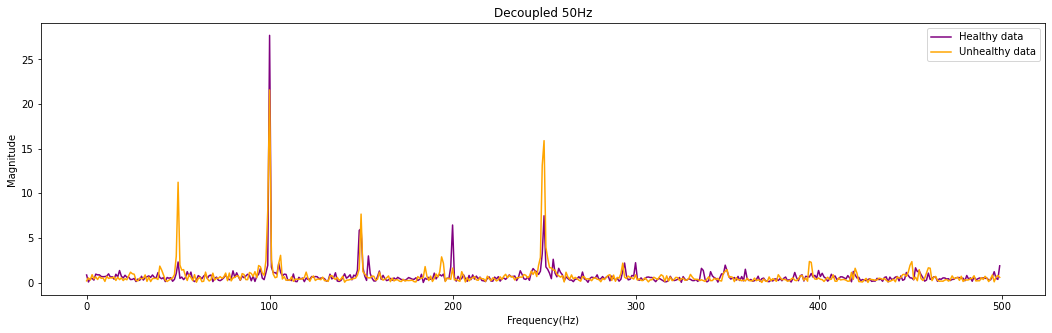

In [14]:
plot_magnitude_spectrum(data50[0,:,0],'Decoupled 50Hz',1000,['Healthy data','Unhealthy data'],0.5,signal2=data_unh50[0,:,0])

## Feature extraction

In [15]:
# Healthy data
motor_features50 = feature_extraction('data_final50.pkz','motor_healthy50.pkz',1000)
motor_features60 = feature_extraction('data_final60.pkz','motor_healthy60.pkz',1000)

# 1 broken bar
motor_unh_features50 = feature_extraction('data_unh_final50.pkz','motor_unh50.pkz',1000)
motor_unh_features60 = feature_extraction('data_unh_final60.pkz','motor_unh60.pkz',1000)

# 2 broken bars
motor_unh_features50_2 = feature_extraction('data_unh_final50_2.pkz','motor_unh50_2.pkz',1000)
motor_unh_features60_2 = feature_extraction('data_unh_final60_2.pkz','motor_unh60_2.pkz',1000)

# 3 broken bars
motor_unh_features50_3 = feature_extraction('data_unh_final50_3.pkz','motor_unh50_3.pkz',1000)
motor_unh_features60_3 = feature_extraction('data_unh_final60_3.pkz','motor_unh60_3.pkz',1000)

Loading features from pickle.
Loading features from pickle.
Loading features from pickle.
Loading features from pickle.
Loading features from pickle.
Loading features from pickle.
Loading features from pickle.
Loading features from pickle.


In [16]:
feature_names = ['mean_abs','std','median','max','skew','kurtosis','RMS','form_factor','zero_crossings',
                'freq_mean','freq_kurtosis','homogenity','0-100hz','100-200hz','200-300hz','300-400hz','400-500hz']

In [17]:
# Concatenating the features of healhty motor having different loads (50 Hz)
motor50 = motor_features50[:,0:17]
for i in range(1,8):
    motor50 = np.concatenate((motor50,motor_features50[:,i*17:(i+1)*17]),axis=0)
    
# Concatenating the features of healhty motor having different loads (60 Hz)
motor60 = motor_features60[:,0:17]
for i in range(1,8):
    motor60 = np.concatenate((motor60,motor_features60[:,i*17:(i+1)*17]),axis=0)
    
# Concatenating for 1 broken bar
motor_unh50 = motor_unh_features50[:,0:17]
for i in range(1,4):
    motor_unh50 = np.concatenate((motor_unh50,motor_unh_features50[:,i*17:(i+1)*17]),axis=0)

motor_unh60 = motor_unh_features60[:,0:17]
for i in range(1,4):
    motor_unh60 = np.concatenate((motor_unh60,motor_unh_features60[:,i*17:(i+1)*17]),axis=0)
    
# Concatenating for 2 broken bar
motor_unh50_2 = motor_unh_features50_2[:,0:17]
for i in range(1,4):
    motor_unh50_2 = np.concatenate((motor_unh50_2,motor_unh_features50_2[:,i*17:(i+1)*17]),axis=0)
    
motor_unh60_2 = motor_unh_features60_2[:,0:17]
for i in range(1,4):
    motor_unh60_2 = np.concatenate((motor_unh60_2,motor_unh_features60_2[:,i*17:(i+1)*17]),axis=0)
    
# Concatenating for 3 broken bar
motor_unh50_3 = motor_unh_features50_3[:,0:17]
for i in range(1,4):
    motor_unh50_3 = np.concatenate((motor_unh50_3,motor_unh_features50_3[:,i*17:(i+1)*17]),axis=0)
    
motor_unh60_3 = motor_unh_features60_3[:,0:17]
for i in range(1,4):
    motor_unh60_3 = np.concatenate((motor_unh60_3,motor_unh_features60_3[:,i*17:(i+1)*17]),axis=0)

## Feature selection

In [18]:
data = np.concatenate((motor50,motor_unh50))
df = pd.DataFrame(data,columns=feature_names)
df['target'] = 0
df.iloc[5120:,-1] = 1

In [19]:
df.head()

,mean_abs,std,median,max,skew,kurtosis,RMS,form_factor,zero_crossings,freq_mean,freq_kurtosis,homogenity,0-100hz,100-200hz,200-300hz,300-400hz,400-500hz,target
0,0.041859,0.048816,-0.002883,0.149714,0.223327,-0.846277,0.048823,58.021662,214.0,0.684527,289.869794,40.473665,0.897794,0.777429,0.746811,0.478093,0.520872,0
1,0.042324,0.050059,-0.002883,0.129093,0.032111,-0.816703,0.050060,161.777382,250.0,0.709234,224.805979,37.391817,0.836192,0.939152,0.788338,0.483546,0.496816,0
2,0.042978,0.050873,-0.002883,0.129093,0.096079,-0.749390,0.050874,152.232643,227.0,0.719703,267.849502,39.217155,0.901009,0.939492,0.755106,0.497169,0.503581,0
3,0.043517,0.051207,-0.002883,0.137342,0.089507,-0.875177,0.051208,-234.399127,250.0,0.745398,247.846109,37.148250,0.945747,0.923831,0.789299,0.565337,0.500324,0
4,0.043635,0.052085,0.001242,0.137342,-0.040727,-0.772091,0.052086,229.497513,253.0,0.757215,241.587433,36.897492,0.997061,0.985698,0.776688,0.478999,0.545514,0


In [20]:
X,y = df.iloc[:,:-1].values,df.iloc[:,-1].values

model = xgb.XGBClassifier(random_state=0)

model.fit(X,y)

[22:41:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
model.score(X,y)

1.0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

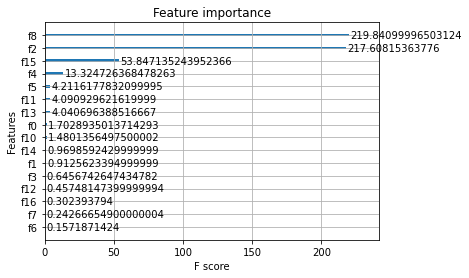

In [22]:
xgb.plot_importance(model,importance_type='gain')

In [23]:
result = permutation_importance(model,X,y,n_repeats=10,random_state=0)
result.importances_mean

array([7.81250000e-05, 9.11458333e-05, 1.26692708e-01, 1.56250000e-04,
       1.05468750e-03, 5.85937500e-04, 0.00000000e+00, 0.00000000e+00,
       3.19570313e-01, 0.00000000e+00, 0.00000000e+00, 5.85937500e-04,
       0.00000000e+00, 7.81250000e-05, 0.00000000e+00, 1.47656250e-02,
       0.00000000e+00])

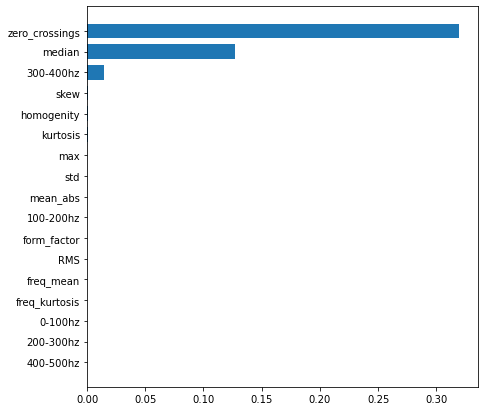

In [24]:
perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(7,7))
indices = np.arange(0,len(result.importances_mean))
plt.barh(indices,result.importances_mean[perm_sorted_idx],height = 0.7)
plt.yticks(ticks = indices,labels=np.array(feature_names+['slip'])[perm_sorted_idx])
plt.show()

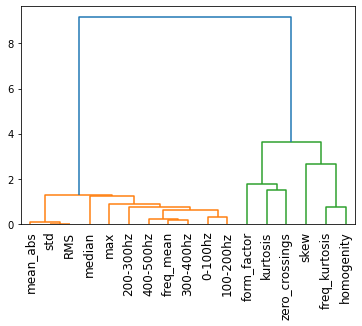

In [25]:
# Using spearman rank correlation and plotting the dendogram

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, leaf_rotation=90
)

In [26]:
from collections import defaultdict

# Perform hierarchical clustering and include the first features of the clusters
cluster_ids = hierarchy.fcluster(corr_linkage,1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# 10 out of 19 features selected
selected_features    

[0, 2, 3, 4, 5, 7, 8, 10]

In [27]:
feature_names = np.array(feature_names+['slip'])

In [28]:
feature_names[selected_features]

array(['mean_abs', 'median', 'max', 'skew', 'kurtosis', 'form_factor',
       'zero_crossings', 'freq_kurtosis'], dtype='<U14')

In [29]:
X = df.iloc[:,selected_features].values
y = df.iloc[:,-1].values
model2 = xgb.XGBClassifier(random_state=0)
model2.fit(X,y)

[22:41:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
model2.score(X,y)

1.0

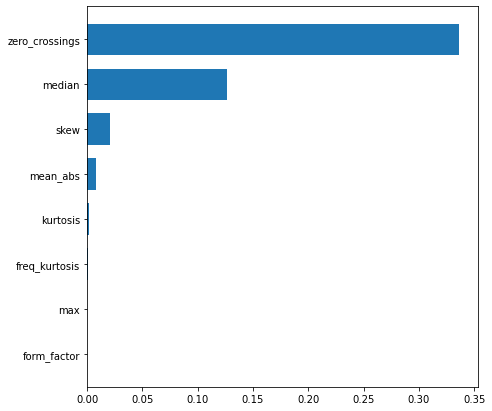

In [31]:
result2 = permutation_importance(model2,X,y,n_repeats=10,random_state=0)
perm_sorted_idx = result2.importances_mean.argsort()
plt.figure(figsize=(7,7))
indices = np.arange(0,len(result2.importances_mean))
plt.barh(indices,result2.importances_mean[perm_sorted_idx],height = 0.7)
plt.yticks(ticks = indices,labels=np.array(feature_names[selected_features])[perm_sorted_idx])
plt.show()

In [32]:
feature_names

array(['mean_abs', 'std', 'median', 'max', 'skew', 'kurtosis', 'RMS',
       'form_factor', 'zero_crossings', 'freq_mean', 'freq_kurtosis',
       'homogenity', '0-100hz', '100-200hz', '200-300hz', '300-400hz',
       '400-500hz', 'slip'], dtype='<U14')

In [33]:
# features_selected = [0,2,4,8,16]
features_selected = [0,2,4,8,15,17]
features_selected = np.array(features_selected)

In [34]:
feature_names = np.array(feature_names)
features = feature_names[features_selected]

In [35]:
# Adding slip for healthy motor data (50 Hz) 
slips = [0.4,0.4,3,2.4,1.8,3,2.4,3]
slip_feature = np.zeros((motor50.shape[0],1))
for i in range(8):
    slip_feature[i*640:(i+1)*640,0] = slips[i]
motor50 = np.concatenate((motor50,slip_feature),axis=1)

# Adding slip for healthy motor data (60 Hz) 
slips = [0.4,0.4,2.8,2.2,1.5,2.8,2.2,1.5]
slip_feature = np.zeros((motor60.shape[0],1))
for i in range(8):
    slip_feature[i*640:(i+1)*640,0] = slips[i]
motor60= np.concatenate((motor60,slip_feature),axis=1)

#Adding slip for 1 broken rotor bar motor (50 Hz)
slips = [0.4,3,2.4,1.8]
slip_feature = np.zeros((motor_unh50.shape[0],1))
for i in range(4):
    slip_feature[i*640:(i+1)*640] = slips[i]
motor_unh50 = np.concatenate((motor_unh50,slip_feature),axis=1)

# Adding slip for 2 broken rotor bar motor (50 Hz)
slips = [0.4,3,2.4,1.8]
slip_feature = np.zeros((motor_unh50_2.shape[0],1))
for i in range(4):
    slip_feature[i*640:(i+1)*640] = slips[i]
motor_unh50_2 = np.concatenate((motor_unh50_2,slip_feature),axis=1)

# Adding slip for 3 broken rotor bar motor (50 Hz)
slips = [0.4,3,2.4,1.8]
slip_feature = np.zeros((motor_unh50_3.shape[0],1))
for i in range(4):
    slip_feature[i*640:(i+1)*640] = slips[i]
motor_unh50_3 = np.concatenate((motor_unh50_3,slip_feature),axis=1)

# Adding slip for 1 broken rotor bar motor (60 Hz)
slips = [0.4,2.8,2.2,1.5]
slip_feature = np.zeros((motor_unh60.shape[0],1))
for i in range(4):
    slip_feature[i*640:(i+1)*640] = slips[i]
motor_unh60 = np.concatenate((motor_unh60,slip_feature),axis=1)

# Adding slip for 2 broken rotor bar motor (60 Hz)
slips = [0.4,2.8,2.2,1.5]
slip_feature = np.zeros((motor_unh60_2.shape[0],1))
for i in range(4):
    slip_feature[i*640:(i+1)*640] = slips[i]
motor_unh60_2 = np.concatenate((motor_unh60_2,slip_feature),axis=1)

# Adding slip for 3 broken rotor bar motor (60 Hz)
slips = [0.4,2.8,2.2,1.5]
slip_feature = np.zeros((motor_unh60_3.shape[0],1))
for i in range(4):
    slip_feature[i*640:(i+1)*640] = slips[i]
motor_unh60_3 = np.concatenate((motor_unh60_3,slip_feature),axis=1)

In [36]:
motor_sel50 = motor50[:,features_selected]
motor_sel60 = motor60[:,features_selected]
motor_unh_sel50 = motor_unh50[:,features_selected]
motor_unh_sel60 = motor_unh60[:,features_selected]
motor_unh_sel50_2 = motor_unh50_2[:,features_selected]
motor_unh_sel60_2 = motor_unh60_2[:,features_selected]
motor_unh_sel50_3 = motor_unh50_3[:,features_selected]
motor_unh_sel60_3 = motor_unh60_3[:,features_selected]

In [37]:
motor50.shape

(5120, 18)

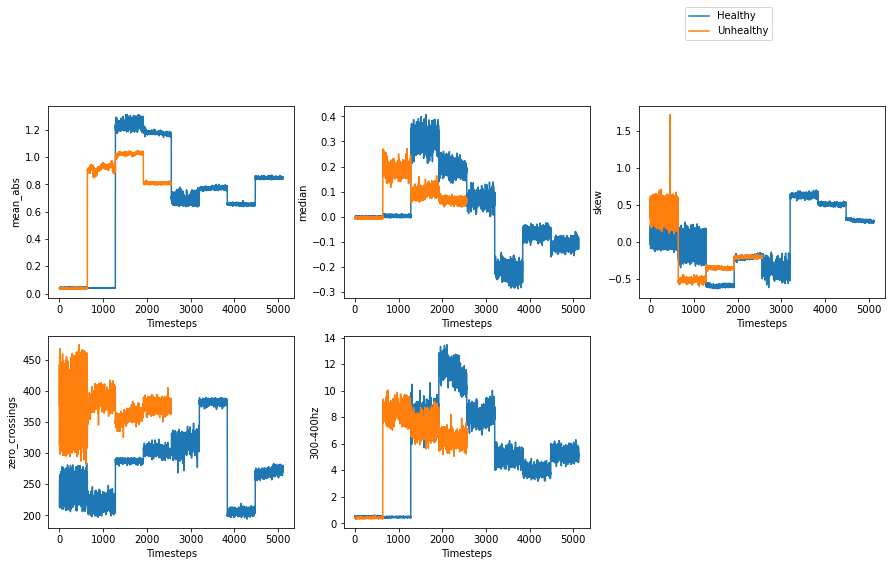

In [38]:
fig = plt.figure(figsize=(15,12))
rows,cols = 3,3
plot_no = 1
    
for col in range(motor_sel50.shape[-1]-1):
    plt.subplot(rows,cols,plot_no)
    plt.plot(motor_sel50[:,col],label='Healthy')
    plt.plot(motor_unh_sel50[:,col],label='Unhealthy')
    plt.ylabel(features[col])
    plt.xlabel('Timesteps')
    plot_no += 1
    
for ax in fig.axes:
    line, label = ax.get_legend_handles_labels()
    
by_label = dict(zip(label,line))

fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

## Building the LSTM Model for 50 Hz

In [40]:
## 3 timesteps
scaler50,X_train, X_test, y_train, y_test = prepare_data(motor_sel50,time_steps=3,test_size=0,scaling_technique='minmax')
y_train = y_train[:,:-1]
# model50,hist = build_model(X_train,y_train,timesteps=3,lstm1_units=100,lstm2_units=50,batch_size=40,epochs=150,learning_rate=0.01,validation_size=0,verbose=1)

In [41]:
# model50.save('model50',save_format='h5')

In [42]:
model50 = tf.keras.models.load_model('model50')

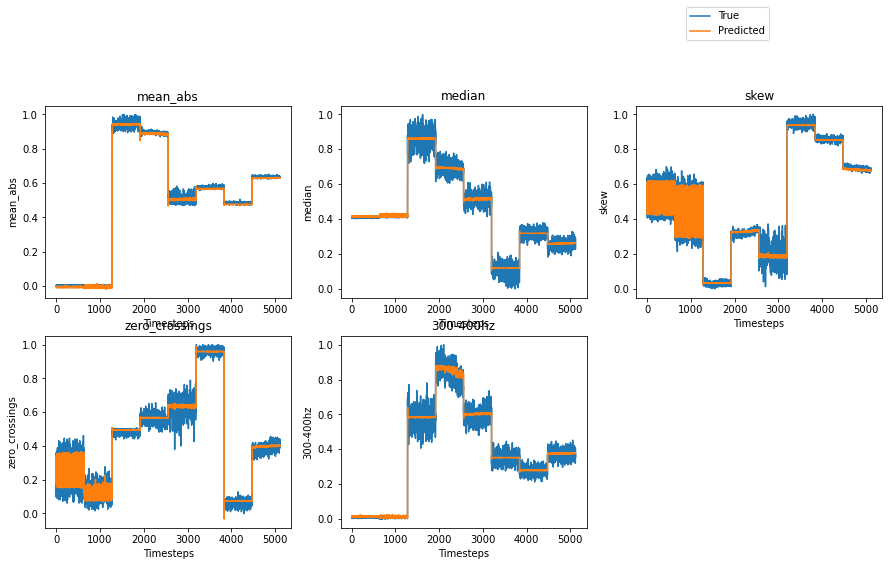

In [43]:
plot_pred_and_actual(motor_sel50,model50,scaler50,3,features[:-1])

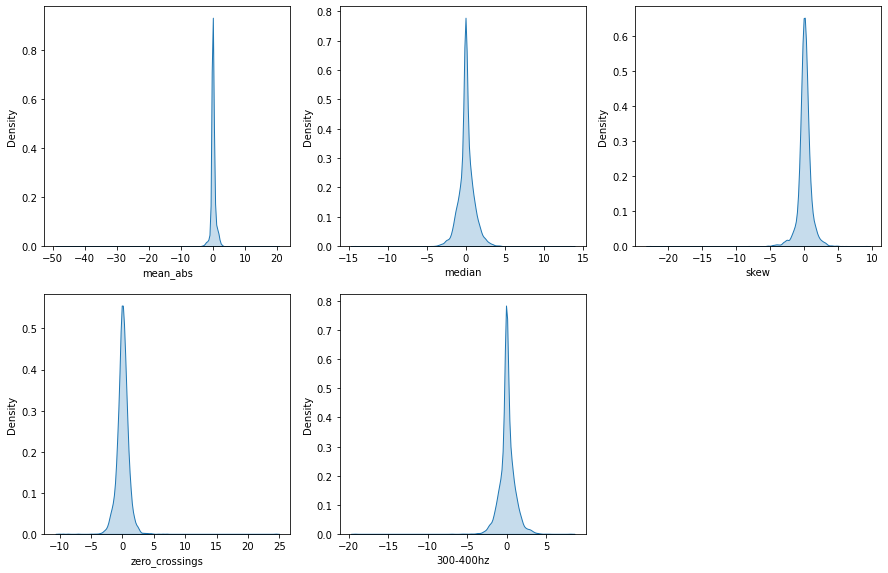

In [44]:
errors_std,normal_errors_std,normal_errors = calc_errors(motor_sel50,model50,scaler50,3,features[:-1],len(motor_sel50))

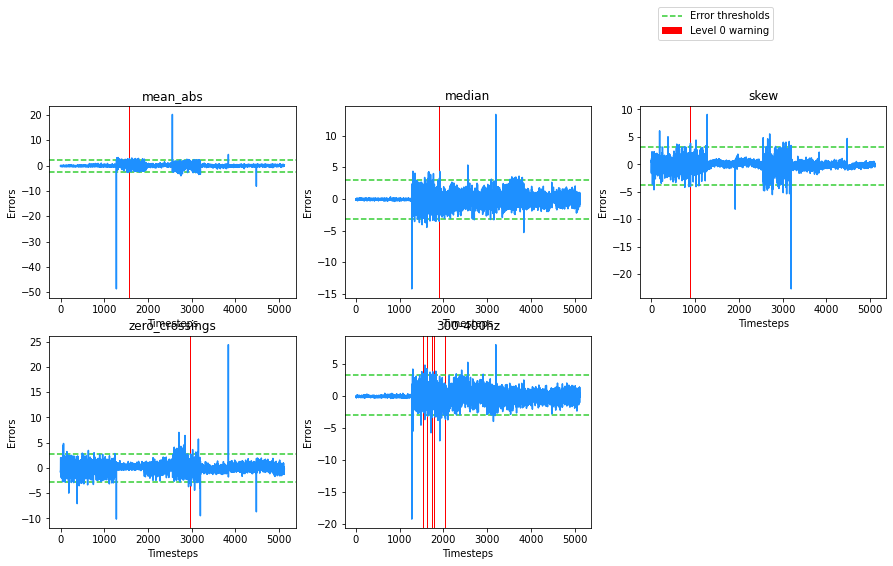

In [45]:
normal_dist_errors = [False,False,False,False,False]
anomaly(normal_errors_std,errors_std,normal_dist_errors,features[:-1],1,level0_threshold=1,level1_threshold=12,min_delta=0,verbose=0)

### 1 broken bar
Using previously trained model to detect anomaly.

In [46]:
errors_std1,normal_errors_std1 = calc_errors2(motor_unh_sel50,model50,scaler50,normal_errors,3)

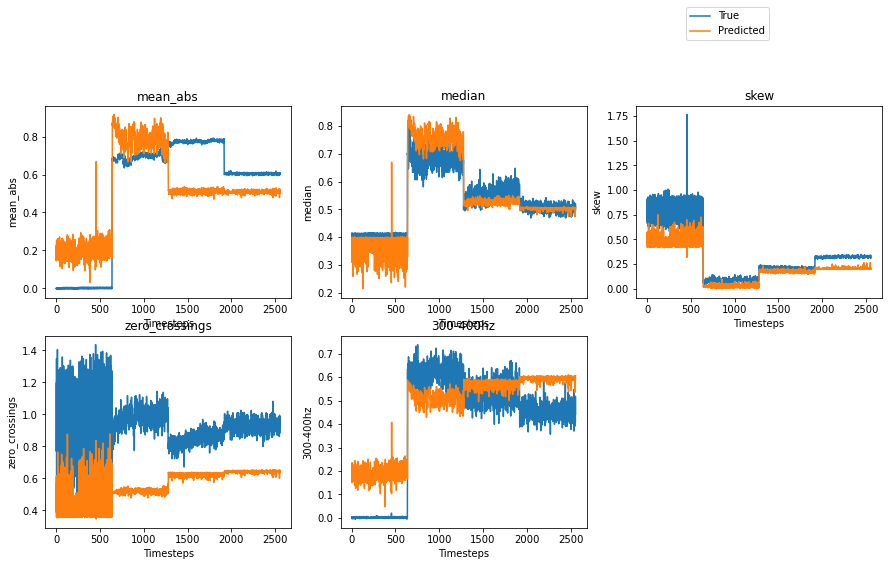

In [47]:
plot_pred_and_actual(motor_unh_sel50,model50,scaler50,3,features[:-1])

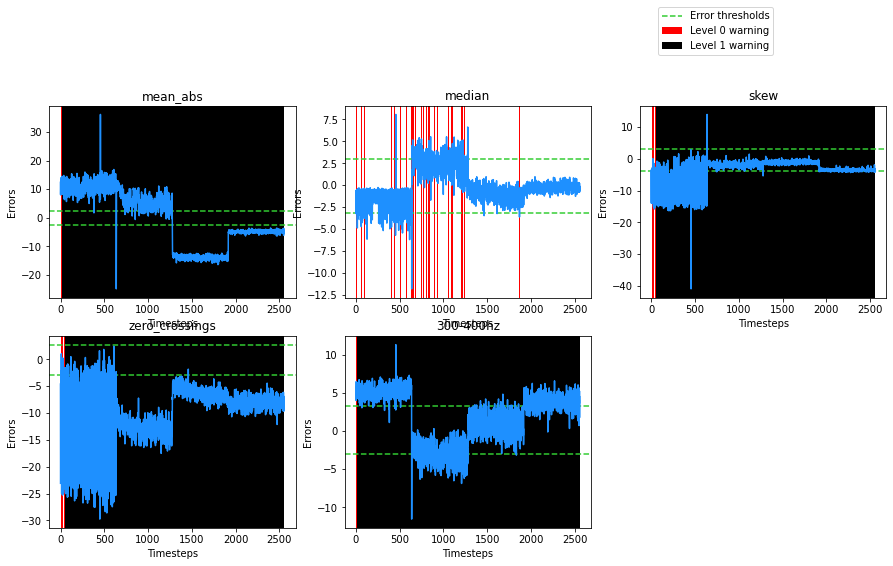

In [48]:
normal_dist_errors = [False,False,False,False,False]
anomaly(normal_errors_std1,errors_std1,normal_dist_errors,features[:-1],1,level0_threshold=1,level1_threshold=12,min_delta=0,verbose=0)

## Trying PCA

In [49]:
motor_sel_pca50,pca_obj50,scaler_prior_pca1 = PrincipalComponent(motor_sel50,2,len(motor_sel50),test_size=0,scaling_technique='minmax')

[0.58971063 0.27962712]


In [50]:
# Build the model
scaler_pca,X_train_pca, X_test_pca, y_train_pca, y_test_pca = prepare_data(motor_sel_pca50,time_steps=3,test_size=0,scaling_technique='minmax')

# model_pca,hist_pca = build_model(X_train_pca,y_train_pca,timesteps=3,lstm1_units=100,lstm2_units=50,batch_size=40,epochs=150,validation_size=0,learning_rate=0.01,verbose=1)

In [51]:
# model_pca.save('model_pca50',save_format='h5')

In [52]:
model_pca = tf.keras.models.load_model('model_pca50')

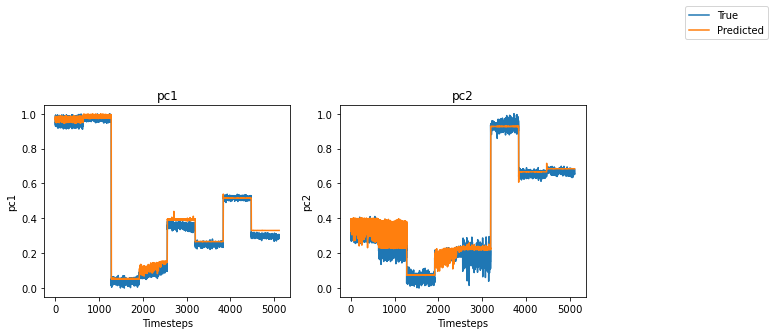

In [53]:
plot_pred_and_actual(motor_sel_pca50,model_pca,scaler_pca,3,['pc1','pc2'])

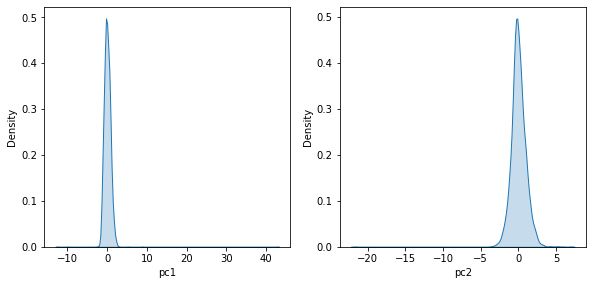

In [54]:
errors_std,normal_errors_std,normal_errors = calc_errors(motor_sel_pca50,model_pca,scaler_pca,3,['pc1','pc2'],len(motor_sel_pca50))

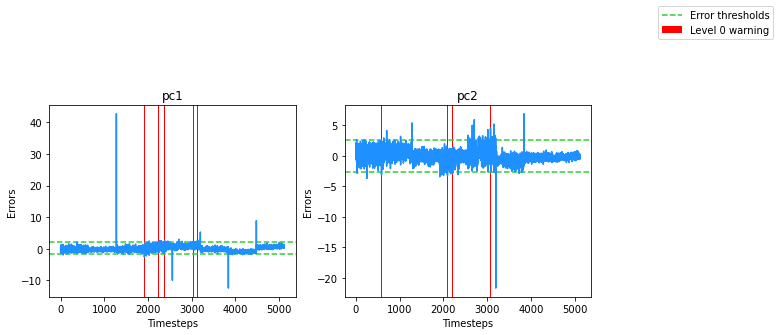

In [55]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std,errors_std,normal_dist_errors,['pc1','pc2'],3,level0_threshold=1,level1_threshold=12,min_delta=0,verbose=0)

## 1 broken bar

In [56]:
motor_unh_sel50_scaled = scaler_prior_pca1.transform(motor_unh_sel50)
motor_unh_sel_pca50 = pca_obj50.transform(motor_unh_sel50_scaled)

In [57]:
errors_std1,normal_errors_std1 = calc_errors2(motor_unh_sel_pca50,model_pca,scaler_pca,normal_errors,3)

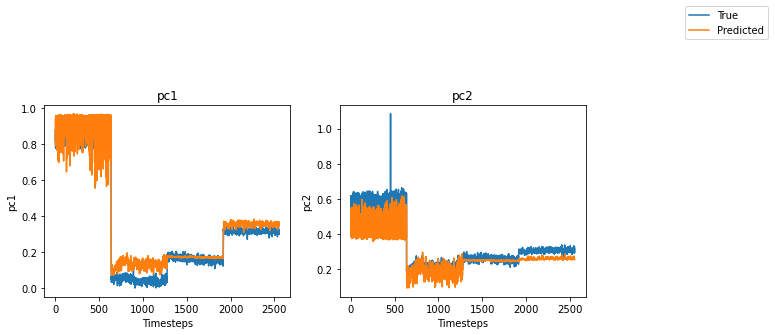

In [58]:
plot_pred_and_actual(motor_unh_sel_pca50,model_pca,scaler_pca,3,['pc1','pc2'])

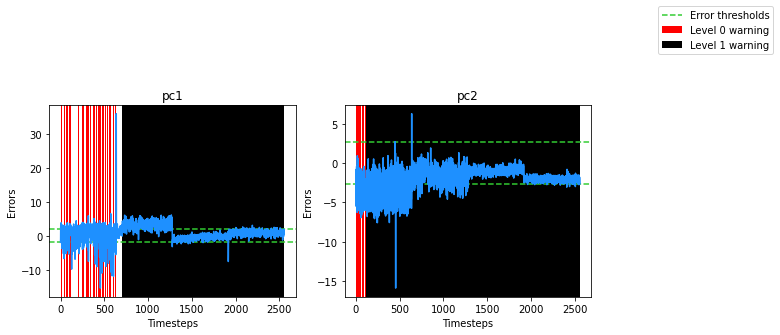

In [59]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std1,errors_std1,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

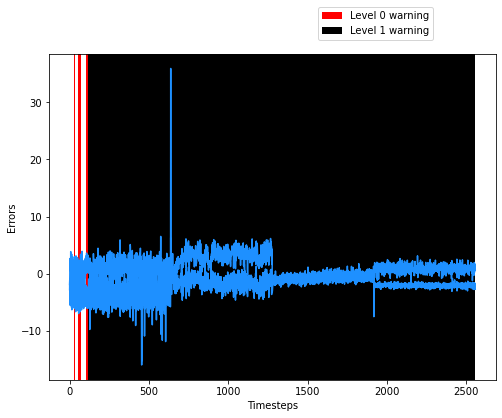

In [61]:
# Detecting jointly
anomaly_joint(normal_errors_std1,errors_std1,[False,False],1,1,6,0,num_rows=1,num_cols=1,figsize=(8,6),verbose=0)

## 2 broken bars

In [62]:
motor_unh_sel50_2scaled = scaler_prior_pca1.transform(motor_unh_sel50_2)
motor_unh_sel_pca50_2 = pca_obj50.transform(motor_unh_sel50_2scaled)

In [63]:
errors_std2,normal_errors_std2 = calc_errors2(motor_unh_sel_pca50_2,model_pca,scaler_pca,normal_errors,3)

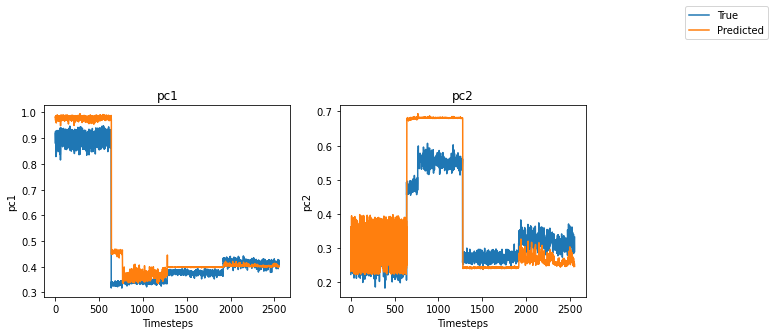

In [64]:
plot_pred_and_actual(motor_unh_sel_pca50_2,model_pca,scaler_pca,3,['pc1','pc2'])

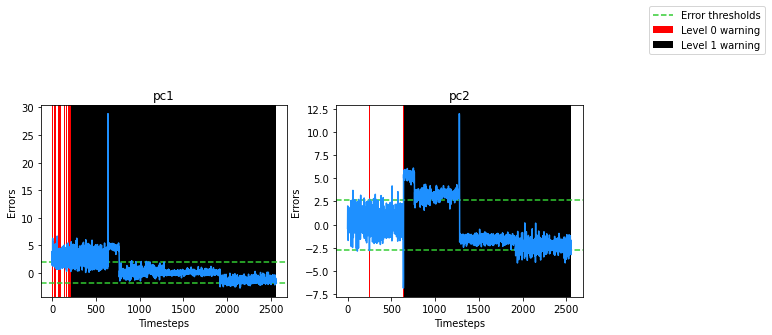

In [65]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std2,errors_std2,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

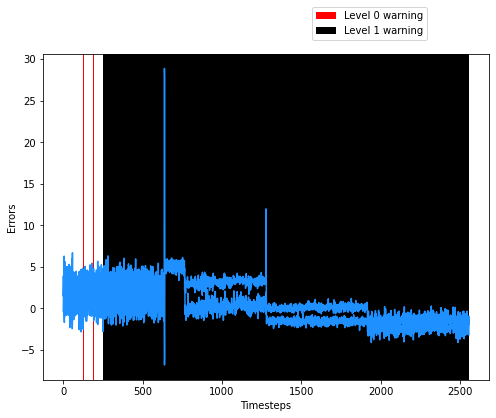

In [66]:
# Detecting jointly
anomaly_joint(normal_errors_std2,errors_std2,[False,False],1,1,6,0,num_rows=1,num_cols=1,figsize=(8,6),verbose=0)

## 3 broken rods

In [67]:
motor_unh_sel50_3scaled = scaler_prior_pca1.transform(motor_unh_sel50_3)
motor_unh_sel_pca50_3 = pca_obj50.transform(motor_unh_sel50_3scaled)

In [68]:
errors_std3,normal_errors_std3 = calc_errors2(motor_unh_sel_pca50_3,model_pca,scaler_pca,normal_errors,3)

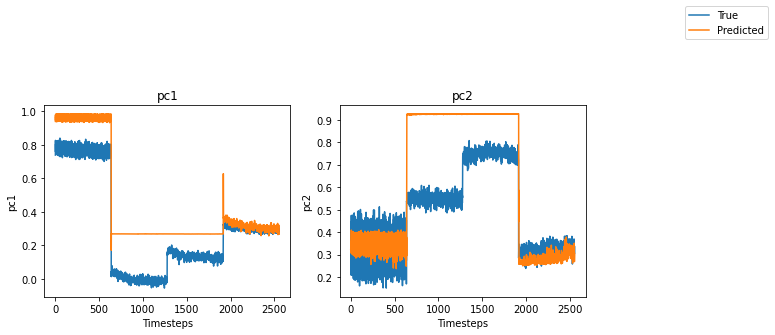

In [69]:
plot_pred_and_actual(motor_unh_sel_pca50_3,model_pca,scaler_pca,3,['pc1','pc2'])

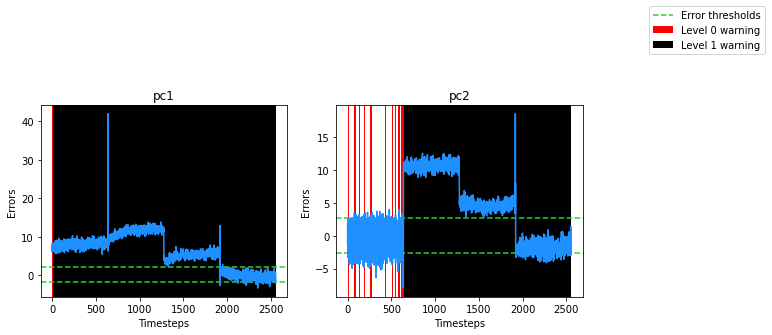

In [70]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std3,errors_std3,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

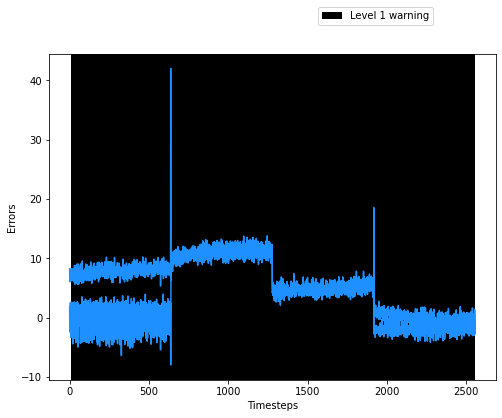

In [71]:
# Detecting jointly
anomaly_joint(normal_errors_std3,errors_std3,[False,False],1,1,6,0,num_rows=1,num_cols=1,figsize=(8,6),verbose=0)

## Building LSTM model for 60 Hz

In [72]:
## 3 timesteps
scaler60,X_train, X_test, y_train, y_test = prepare_data(motor_sel60,time_steps=3,test_size=0,scaling_technique='minmax')
y_train = y_train[:,:-1]
# model60,hist = build_model(X_train,y_train,timesteps=3,lstm1_units=100,lstm2_units=50,batch_size=40,epochs=150,learning_rate=0.01,validation_size=0,verbose=1)

In [73]:
# model60.save('model60',save_format='h5')

In [74]:
model60 = tf.keras.models.load_model('model60')

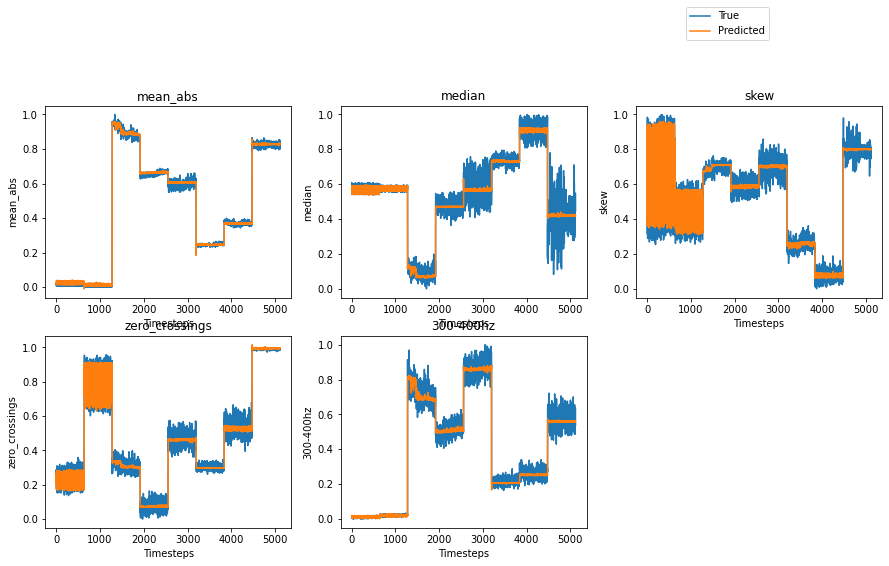

In [75]:
plot_pred_and_actual(motor_sel60,model60,scaler60,3,features[:-1])

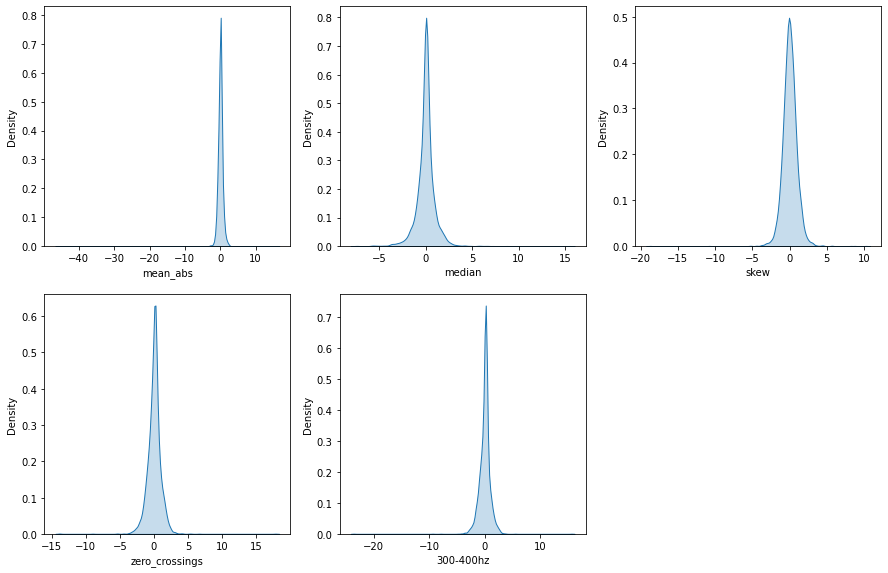

In [76]:
errors_std,normal_errors_std,normal_errors = calc_errors(motor_sel60,model60,scaler60,3,features[:-1],len(motor_sel60))

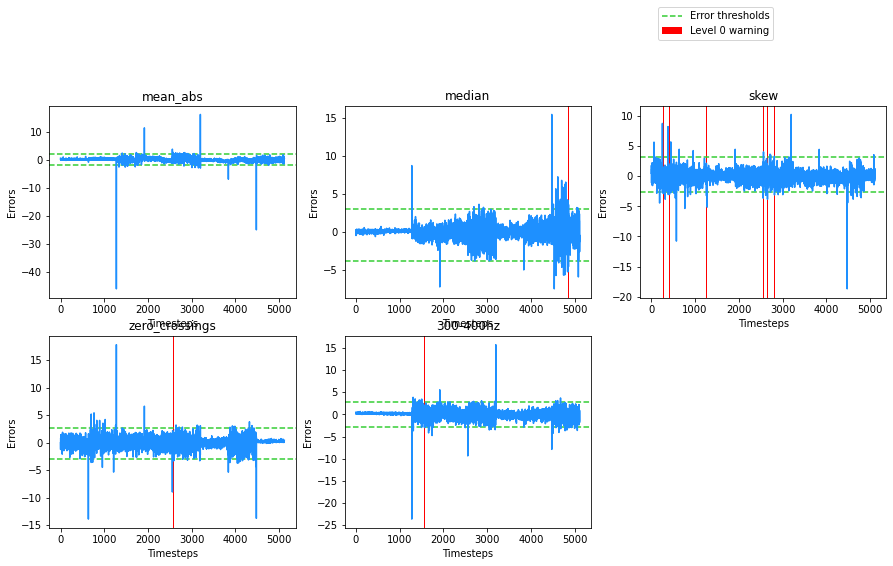

In [77]:
normal_dist_errors = [False,False,False,False,False]
anomaly(normal_errors_std,errors_std,normal_dist_errors,features[:-1],1,level0_threshold=1,level1_threshold=12,min_delta=0,verbose=0)

### 2 broken bars

In [78]:
errors_std1,normal_errors_std1 = calc_errors2(motor_unh_sel60_2,model60,scaler60,normal_errors,3)

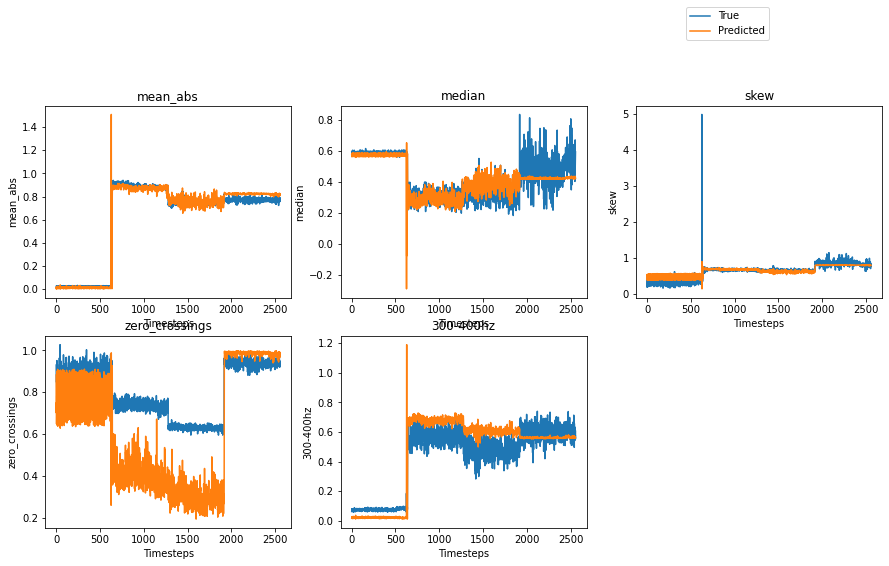

In [79]:
plot_pred_and_actual(motor_unh_sel60_2,model60,scaler60,3,features[:-1])

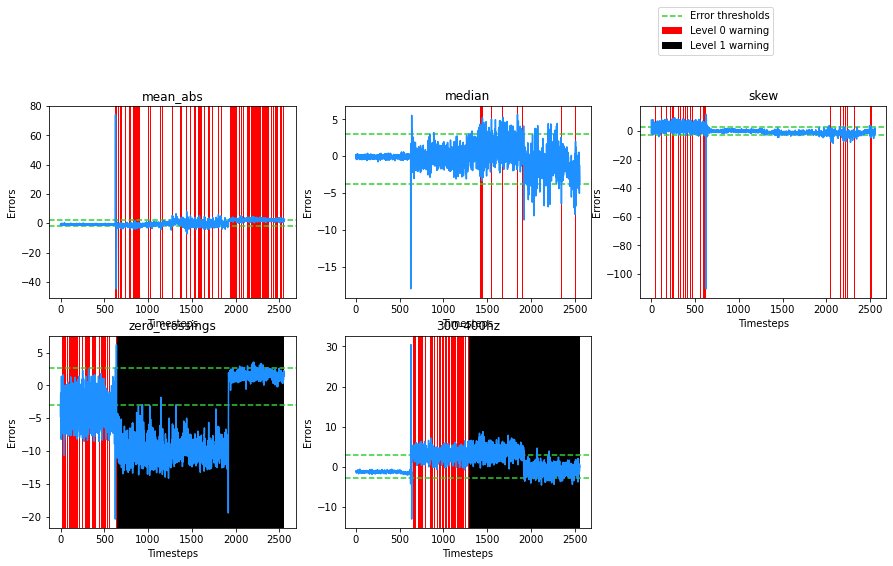

In [80]:
normal_dist_errors = [False,False,False,False,False,False,False]
anomaly(normal_errors_std1,errors_std1,normal_dist_errors,features[:-1],1,level0_threshold=1,level1_threshold=12,min_delta=0,verbose=0)

## Trying PCA

In [81]:
motor_sel_pca60,pca_obj60,scaler_prior_pca2 = PrincipalComponent(motor_sel60,2,len(motor_sel60),test_size=0,scaling_technique='minmax')

[0.51951568 0.26766414]


In [82]:
# Build the model
scaler_pca1,X_train_pca1, X_test_pca1, y_train_pca1, y_test_pca1 = prepare_data(motor_sel_pca60,time_steps=3,test_size=0,scaling_technique='minmax')
# y_train_pca1 = y_train_pca1[:,:-1]
# model_pca1,hist_pca1 = build_model(X_train_pca1,y_train_pca1,timesteps=3,lstm1_units=100,lstm2_units=50,batch_size=40,epochs=150,validation_size=0,learning_rate=0.01,verbose=1)

In [83]:
# model_pca1.save('model_pca60',save_format='h5')

In [84]:
model_pca1 = tf.keras.models.load_model('model_pca60')

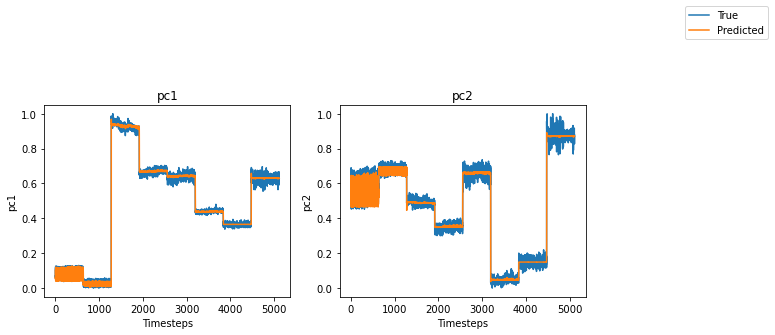

In [85]:
plot_pred_and_actual(motor_sel_pca60,model_pca1,scaler_pca1,3,['pc1','pc2'])

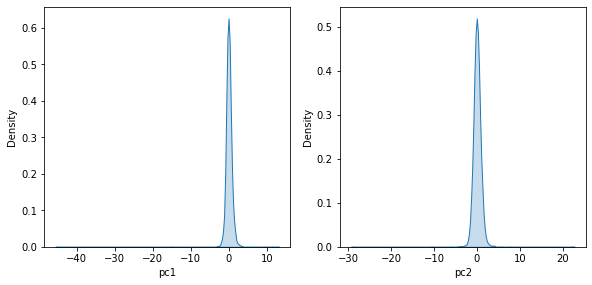

In [86]:
errors_std,normal_errors_std,normal_errors = calc_errors(motor_sel_pca60,model_pca1,scaler_pca1,3,['pc1','pc2'],len(motor_sel_pca60))

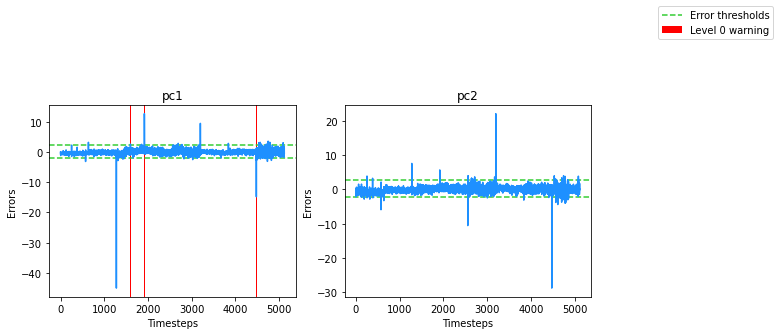

In [87]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std,errors_std,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

## 1 broken bar

In [88]:
motor_unh_sel60scaled = scaler_prior_pca2.transform(motor_unh_sel60)
motor_unh_sel_pca60 = pca_obj60.transform(motor_unh_sel60scaled)

In [89]:
errors_std1,normal_errors_std1 = calc_errors2(motor_unh_sel_pca60,model_pca1,scaler_pca1,normal_errors,3)

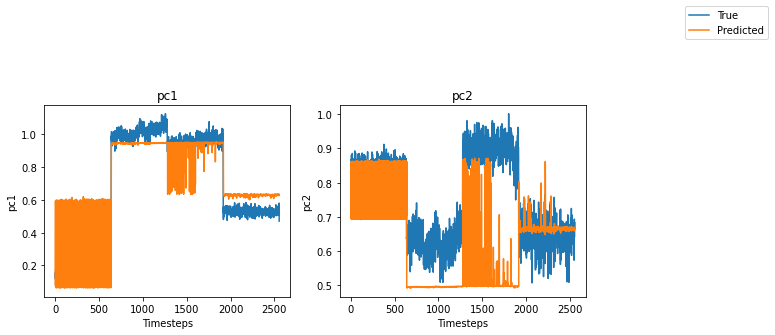

In [90]:
plot_pred_and_actual(motor_unh_sel_pca60,model_pca1,scaler_pca1,3,['pc1','pc2'])

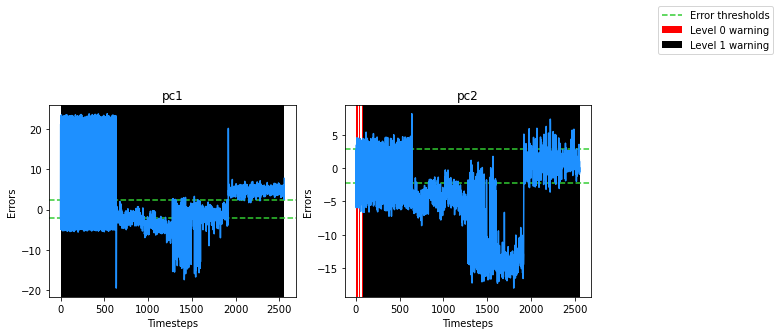

In [91]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std1,errors_std1,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

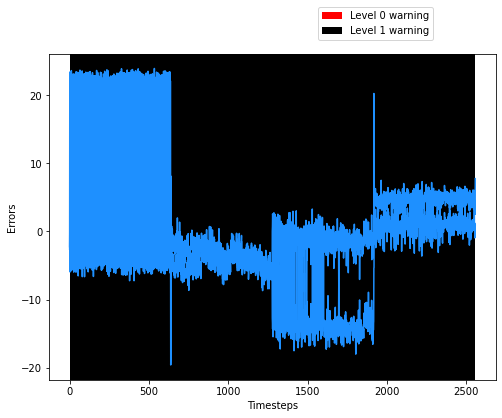

In [93]:
# Detecting jointly
anomaly_joint(normal_errors_std1,errors_std1,[False,False],1,1,6,0,num_rows=1,num_cols=1,figsize=(8,6),verbose=0)

## 2 broken bars

In [94]:
motor_unh_sel60_2scaled = scaler_prior_pca2.transform(motor_unh_sel60_2)
motor_unh_sel_pca60_2 = pca_obj60.transform(motor_unh_sel60_2scaled)

In [95]:
errors_std2,normal_errors_std2 = calc_errors2(motor_unh_sel_pca60_2,model_pca1,scaler_pca1,normal_errors,3)

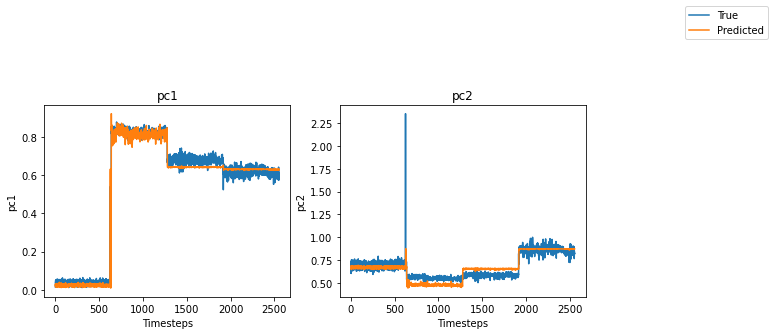

In [96]:
plot_pred_and_actual(motor_unh_sel_pca60_2,model_pca1,scaler_pca1,3,['pc1','pc2'])

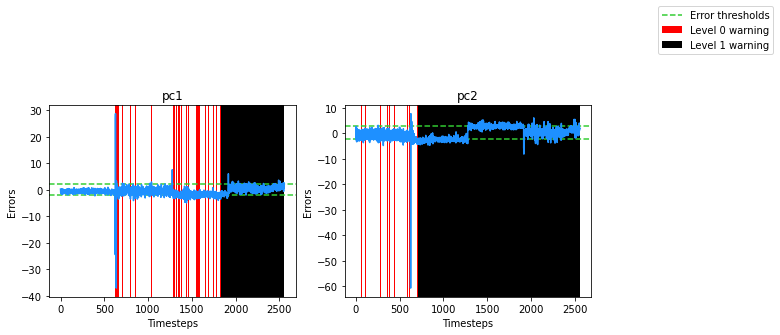

In [97]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std2,errors_std2,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

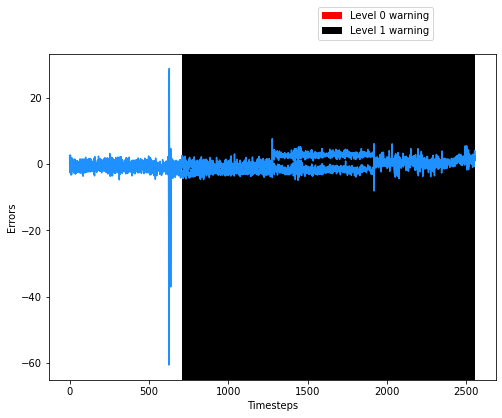

In [98]:
# Detecting jointly
anomaly_joint(normal_errors_std2,errors_std2,[False,False],1,1,6,0,num_rows=1,num_cols=1,figsize=(8,6),verbose=0)

## 3 broken bars

In [99]:
motor_unh_sel60_3scaled = scaler_prior_pca2.transform(motor_unh_sel60_3)
motor_unh_sel_pca60_3 = pca_obj60.transform(motor_unh_sel60_3scaled)

In [100]:
errors_std3,normal_errors_std3 = calc_errors2(motor_unh_sel_pca60_3,model_pca1,scaler_pca1,normal_errors,3)

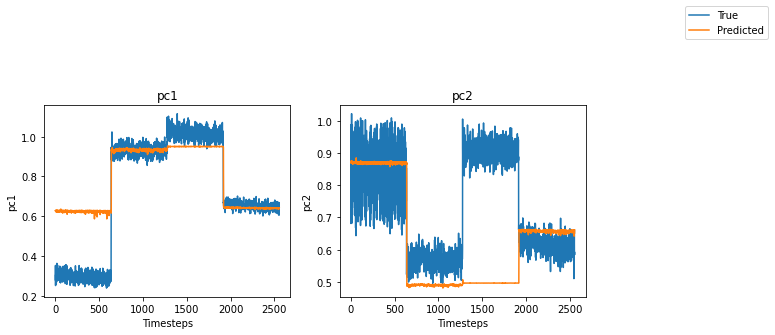

In [101]:
plot_pred_and_actual(motor_unh_sel_pca60_3,model_pca1,scaler_pca1,3,['pc1','pc2'])

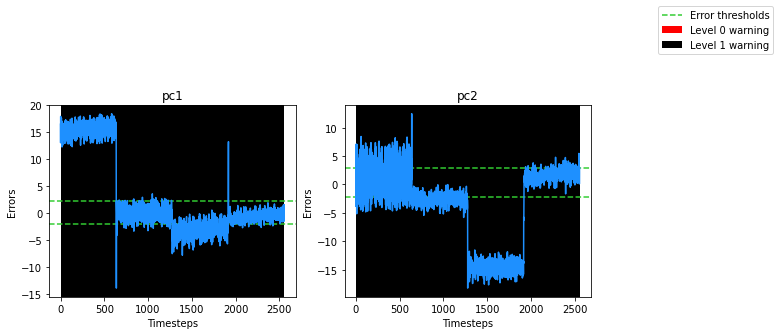

In [102]:
normal_dist_errors = [False,False]
anomaly(normal_errors_std3,errors_std3,normal_dist_errors,['pc1','pc2'],1,level0_threshold=1,level1_threshold=6,min_delta=0,verbose=0)

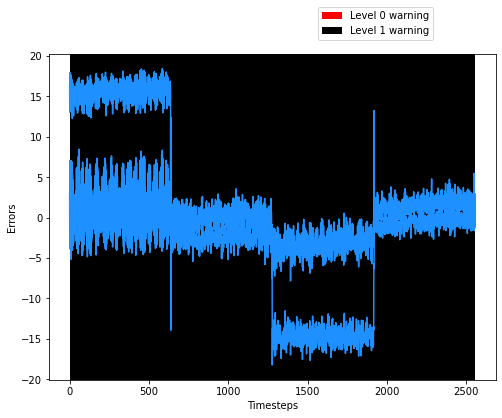

In [103]:
# Detecting jointly
anomaly_joint(normal_errors_std3,errors_std3,[False,False],1,1,6,0,num_rows=1,num_cols=1,figsize=(8,6),verbose=0)

## One class SVM

In [104]:
def model(data, nu,scaler='robust'):
    scaler,data_scaled = scale(data,test_size=0,scaling_technique=scaler)
    svm = OneClassSVM(kernel='rbf',gamma='scale',nu = nu)
    svm.fit(data_scaled)
    return svm, data_scaled,scaler
def plot_distance_matrix(svm, X, max_range, label,hist = True):
    distance_matrix = svm.decision_function(X)

    plt.figure(figsize=(18,10))

    #plots both normal graph and histogram of distance matrix

    plt.subplot(2,1,1)
    plt.plot(distance_matrix[:max_range])
    plt.legend([label])

    if hist:
        plt.subplot(2,1,2)
        plt.hist(distance_matrix[:max_range], bins=90)
        plt.legend([label])
        plt.show()

    print("Skewness of distance matrix: ", skew(distance_matrix)) #print the skewness of distance matrix
    return distance_matrix

### Building model for 50Hz

In [105]:
svm1,motor_sel50_scaled,scaler1 = model(motor_sel50,0.15,'robust')
motor_unh_sel50_scaled = scaler1.transform(motor_unh_sel50)

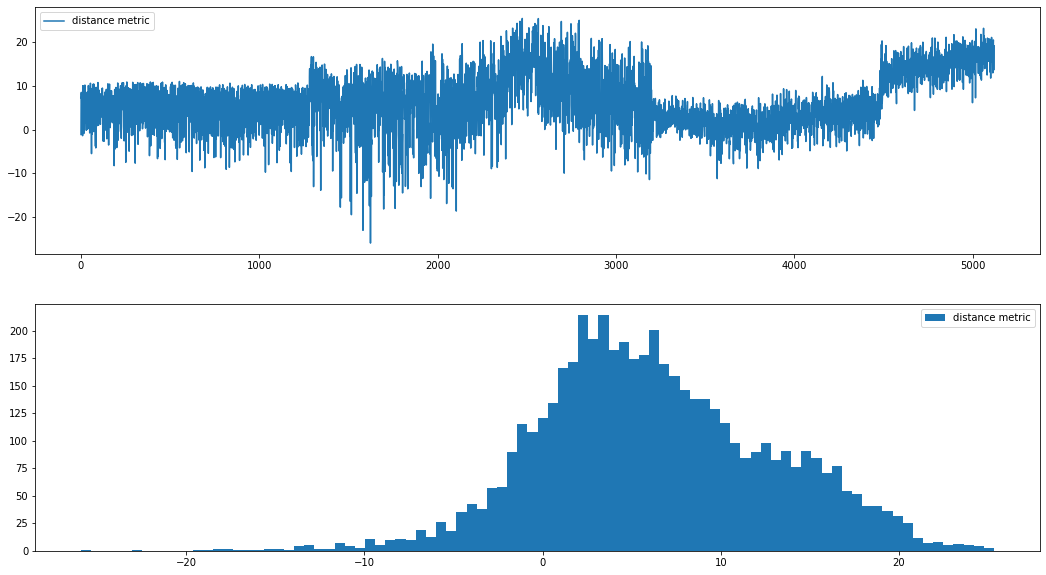

Skewness of distance matrix:  0.045905080636226094


In [106]:
# Healthy distance matrix
distance_matrix_healthy = plot_distance_matrix(svm1,motor_sel50_scaled,len(motor_sel50_scaled),'distance metric')

Skewness of distance matrix:  -1.167820472177431


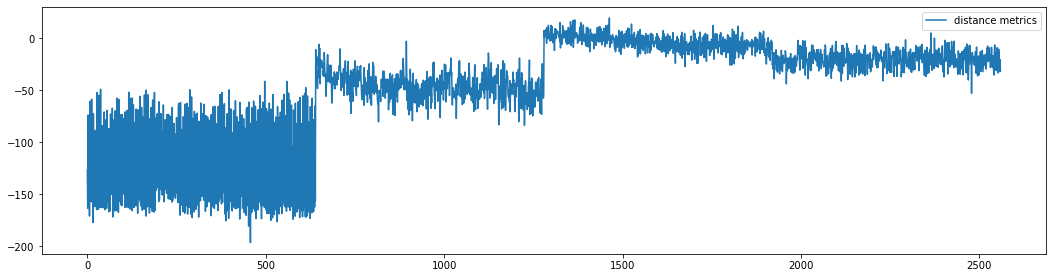

In [107]:
# Distance matrix for 1 broken bar 50 Hz
distance_matrix = plot_distance_matrix(svm1,motor_unh_sel50_scaled,len(motor_unh_sel50_scaled),'distance metrics',False)

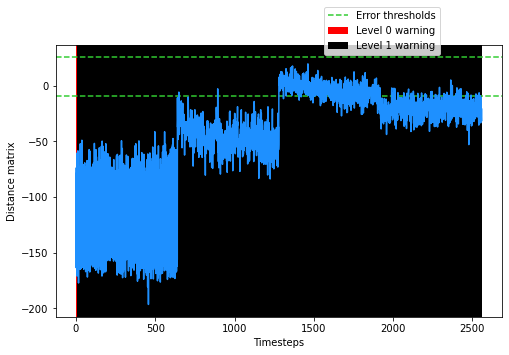

In [109]:
# Anomaly detection for 1 broken bar 50Hz motor
anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,1,1,6,min_delta=0,num_rows=1,num_cols=1,figsize=(8,5),verbose=0)

### Building the model for 60 Hz

In [110]:
svm2,motor_sel60_scaled,scaler2 = model(motor_sel60,0.15,'robust')
motor_unh_sel60_scaled = scaler2.transform(motor_unh_sel60)

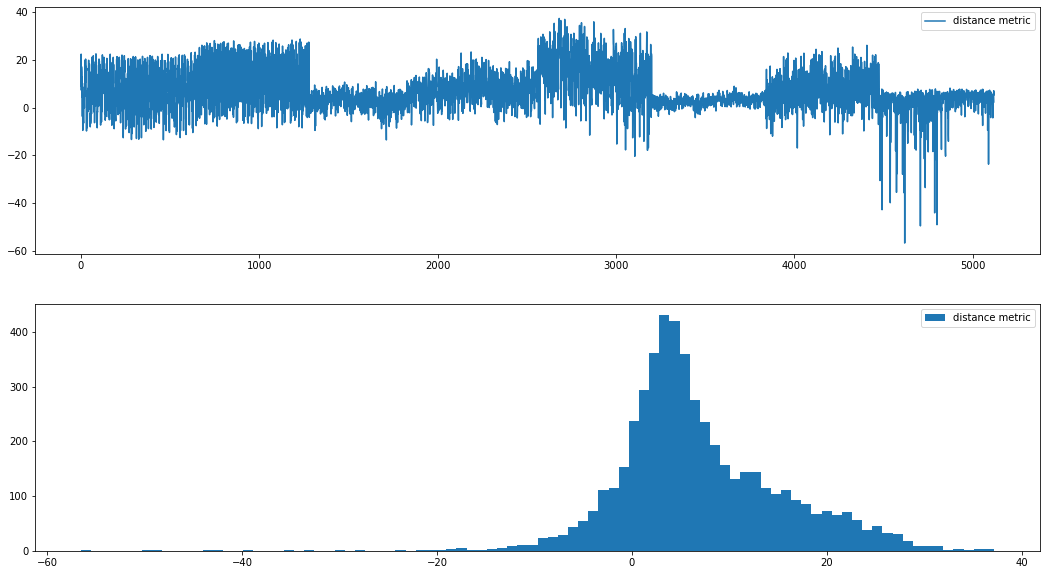

Skewness of distance matrix:  0.09792233955064666


In [111]:
# Healthy distance matrix
distance_matrix_healthy = plot_distance_matrix(svm2,motor_sel60_scaled,len(motor_sel60_scaled),'distance metric')

Skewness of distance matrix:  0.4058956374905282


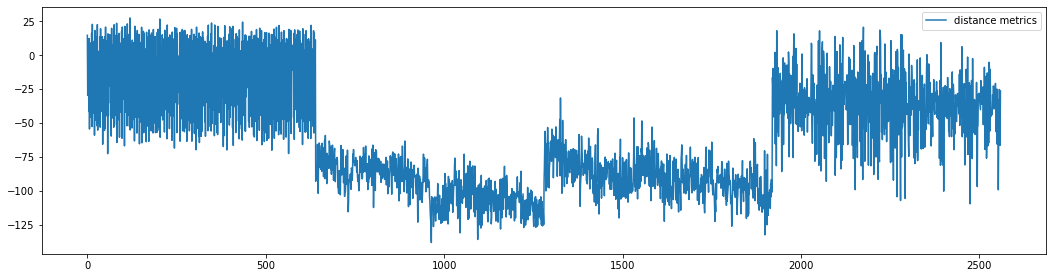

In [112]:
# Distance matrix for 1 broken bar 60 Hz
distance_matrix = plot_distance_matrix(svm2,motor_unh_sel60_scaled,len(motor_unh_sel60_scaled),'distance metrics',False)

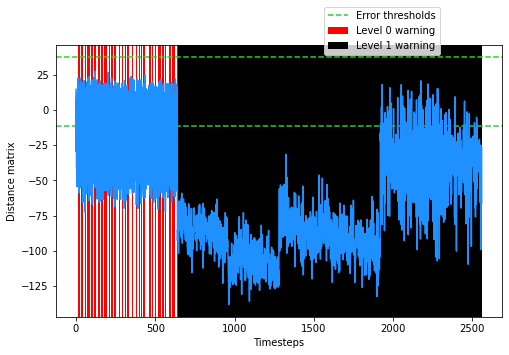

In [114]:
# Anomaly detection for 1 broken bar 60 Hz
anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,1,1,6,min_delta=0,num_rows=1,num_cols=1,figsize=(8,5),verbose=0)

## 2 broken rods motor

In [115]:
motor_unh_sel50_2_scaled = scaler1.transform(motor_unh_sel50_2)

Skewness of distance matrix:  -1.3354100627410537


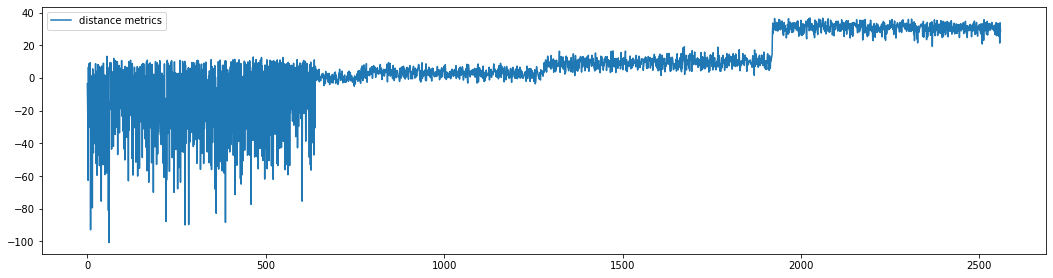

In [116]:
# Distance for 2 broken bar 50 Hz
distance_matrix = plot_distance_matrix(svm1,motor_unh_sel50_2_scaled,len(motor_unh_sel50_2_scaled),'distance metrics',False)

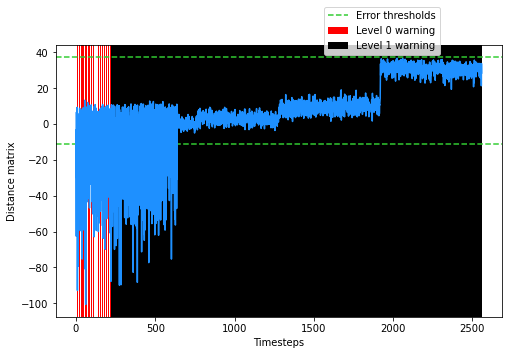

In [117]:
# Anomaly detection for 2 broken bar 60 Hz
anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,1,1,6,min_delta=0,num_rows=1,num_cols=1,figsize=(8,5),verbose=0)

Skewness of distance matrix:  -0.2852145924841238


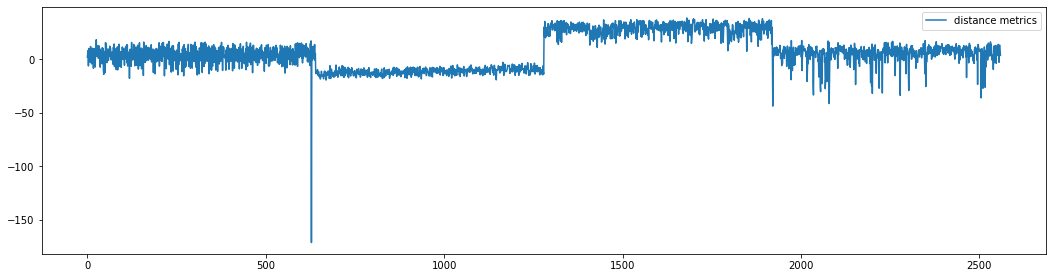

In [118]:
motor_unh_sel60_2_scaled = scaler2.transform(motor_unh_sel60_2)
# Distance matrix for 2 broken bar 60 Hz
distance_matrix = plot_distance_matrix(svm2,motor_unh_sel60_2_scaled,len(motor_unh_sel60_2_scaled),'distance metrics',False)

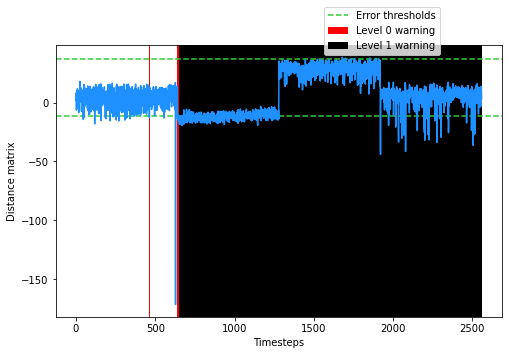

In [120]:
# Anomaly detection for 2 broken bar 60 Hz
anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,1,1,6,min_delta=0,num_rows=1,num_cols=1,figsize=(8,5),verbose=0)

## 3 broken rods

In [121]:
motor_unh_sel50_3_scaled = scaler1.transform(motor_unh_sel50_3)
motor_unh_sel60_3_scaled = scaler2.transform(motor_unh_sel60_3)

Skewness of distance matrix:  0.12394417430030205


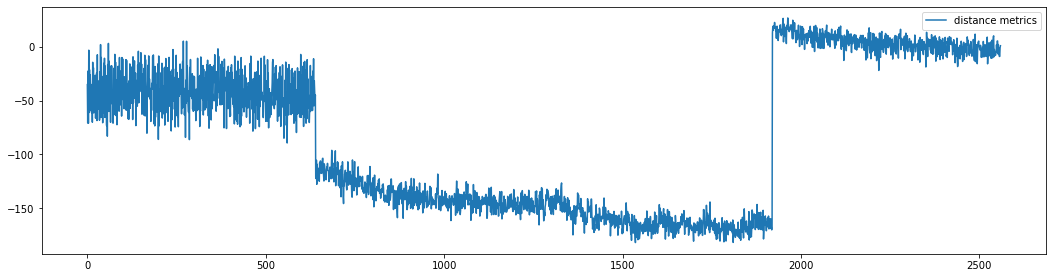

In [122]:
# Distance matrix for 3 broken bar 50 Hz
distance_matrix = plot_distance_matrix(svm1,motor_unh_sel50_3_scaled,len(motor_unh_sel50_3_scaled),'distance metrics',False)

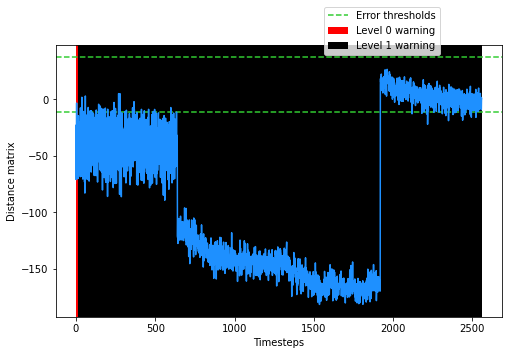

In [123]:
# Anomaly detection for 3 broken bar 50 Hz
anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,1,1,6,min_delta=0,num_rows=1,num_cols=1,figsize=(8,5),verbose=0)

Skewness of distance matrix:  -0.11160161672034544


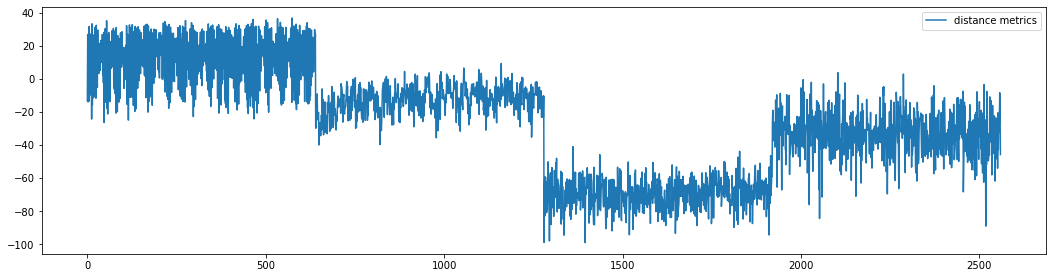

In [124]:
# Distance matrix for 3 broken bar 60 Hz
distance_matrix = plot_distance_matrix(svm2,motor_unh_sel60_3_scaled,len(motor_unh_sel60_3_scaled),'distance metrics',False)

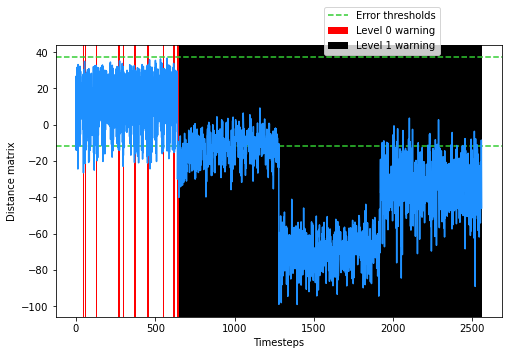

In [125]:
# Anomaly detection for 3 broken bar 60 Hz
anomaly_distance_matrix(distance_matrix,distance_matrix_healthy,1,1,6,min_delta=0,num_rows=1,num_cols=1,figsize=(8,5),verbose=0)